In [74]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from pathlib import Path
import matplotlib as mpl

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [77]:
class ScenarioEnsemble:
    # get the median aggregate scenario ensemble for an individual model given a set of projections for >1 scenario
    # reported in quantile format.
    
    # this method takes the average of all quantiles to find one projection that is an ensemble of all scenarios.
    # performed for all projection locations reported in the given DataFrame
    
    # Input dataframe must have: location, scenario_id, target_end_date, target, value, type, and quantile columns
    
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with all scenarios, locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date
        self.start_week = start_week # beginning of observations of interest
        self.end_week = end_week # end of observations of interest
        self.locations = pd.DataFrame()
        self.scenario_ensemble = pd.DataFrame()
        
        
    def get_locations(self):
        # get df with US state names, populations, and abbreviations and corresponding numerical code 
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
        
        self.locations = locations
        
        
    def get_observations(self, target_location):
        # get and format surveillance data of interest
        observations = self.obsdf.copy()
        
        if self.target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = self.target
            
        # read in observations dataframe
        observations = self.obsdf.copy()
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week
        if self.start_week:
            observations = observations[(observations['date'] >= pd.to_datetime(self.start_week.startdate())) ]
            
        if self.end_week:
            observations = observations[(observations['date'] <= pd.to_datetime(self.end_week.enddate()))]
                                

        #filter location
        observations = observations[observations['location'] == target_location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        if self.max_date:
            observations = observations[observations['date'] <= max_date].copy()

        #transform to Observation object
        observations = Observations(observations)

        return observations
    

        
    def get_scenarioensemble(self):
        # calculate scenario ensemble for all locations with quantiles reported in the input df
        predictions = self.df
        
        loclist = list(predictions.location.unique())
        
        
        median_ensembles = pd.DataFrame()
        for l in loclist: # loop through all locations
            
            if l in ['66', '72']:
                continue
            
            
            target_location = l
            
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            
            pred = predictions[predictions['location'] == target_location].copy()
                                               
            target_prediction_list = [f"{i} wk ahead {'inc' if self.inc else 'cum'} {self.target}" for \
                                      i in range(1,len(list(pred.target_end_date.unique()))+1)]
                ## might need to change if data in different format, this is for ensemble^2 rounds 5-16 
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if self.max_date:
                pred = pred[pred['target_end_date'] <= self.max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            # calculate scenario ensemble
            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], 
                                            t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            
            med_ensemble_predictions['location'] = target_location
            med_ensemble_predictions['target'] = self.target
                                               
            median_ensembles = pd.concat([median_ensembles, med_ensemble_predictions])
                                               
            predictions_list += [med_ensemble_predictions]
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Scenario ensemble"]

        self.scenario_ensemble = median_ensembles
        
        return median_ensembles
          
        
class Scoring(ScenarioEnsemble):
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, MAPE, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi package to calculate the scores 
    # score dataframe must have 'Model' column to differentiate and calculate scores for different models
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, target, incidence, max_date, start_week, end_week)
        self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self):
        predictions = self.scoredf.copy()
        #predictions = Predictions(predictions, t_col = 'target_end_date')
        
        allscore = {}
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                
                if target_location in ['60','66','69', '72', '78']:
                    continue
                
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                try:
                    d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False)

                    allscore[model][target_location] = d
                except Exception as e:
                    print(e)
                    print(target_location)
                    
            
        
        return allscore
    
    def organize_average_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores()
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                
                    
                scoresloc = scoresmod[loc]

                scoredict = {'Model': model ,'location': loc}
                for score in want_scores:
                    scoredict[score] = scoresloc[score]


                average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    def get_all_timestamped_scores(self):
        predictions = self.scoredf.copy()
        
        allscore = {}
        
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                if target_location in ['60','66','69', '72', '78']:
                    continue
                    
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                allscore[model][target_location] = {}
                for t in pred.target_end_date.unique():
                    prednew = pred[pred.target_end_date == t]
                    obsnew = observations[observations.date == t]

                    obsnew = Observations(obsnew)
                    prednew = Predictions(prednew, t_col = 'target_end_date')

                    d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                    allscore[model][target_location][t] = d

        #self.allavgscores = allscore
        
        return allscore
    
    def organize_timestamped_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis'
        
        time_scores = pd.DataFrame()
        
        allscore = self.get_all_timestamped_scores()
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    tdf = scoresloc[t]

                    scoredict = {'Model':model ,'location':loc, 'target_end_date':t}
                    for score in want_scores:
                        scoredict[score] = tdf[score]


                    time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores
    
    
    def get_rescaled_wis(self):
        # calculate WIS rescaled by standard deviation 
        # need to have WIS scores for multiple models
        
        time_scores = self.organize_timestamped_scores(['wis'])
        
        time_scores = time_scores[~time_scores['location'].isin(['60','66','69', '72', '78'])]
        
        wisstdev = pd.DataFrame()
        for loc in time_scores.location.unique():
            for date in time_scores.target_end_date.unique():
                df = time_scores[(time_scores.location == loc) & (time_scores.target_end_date == date)]
                
                stdev = df['wis'].std()
                
                df['wis_scaled'] = df['wis'] / stdev
                
                wisstdev = pd.concat([wisstdev, df])
                
        wisstdev = wisstdev.reset_index()
        wisstdev = wisstdev.drop(columns=['index'])
        
        return wisstdev
    
    
    def get_wis_ratios(self, numerator_model, denominator_model, timestamped=False):
        # need all models of interest in score df so we can calculate wis of each
        # input is numerator model and denominator model to calculate wis ratio
        # input whether you want ratio taken at each time point or over average of whole time window
        
        if timestamped == True:
            scores = self.organize_timestamped_scores(['wis'])
        else:
            scores = self.organize_average_scores(['wis_mean'])
            scores = scores.rename(columns={'wis_mean':'wis'})
            
        num = scores[scores.Model == numerator_model]
        num = num.rename(columns={"wis": "wis_num"})
        
        denom = scores[scores.Model == denominator_model]
        denom = denom.rename(columns={"wis": "wis_denom"})
        
        if timestamped == True:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location', 'target_end_date'])
        else:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location'])
            
        scoresmerge['wis_ratio'] = scoresmerge['wis_num'] / scoresmerge['wis_denom']
        
        return scoresmerge
        


In [5]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [7]:
modelsall = ['CU-AGE-ST', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed', 'Ensemble', 'JHU_IDD-CovidSP', 'Karlen-pypm',
             'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha', 'UVA-adaptive', 'JHUAPL-Bucky', 'UNCC-hierbin', 'UVA-EpiHiper',
            'COVIDhub-baseline_4wks', 'COVIDhub-ensemble_4wks']

In [8]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022, 13)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd12 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
        predictions = predictions[(predictions['target_end_date'] <= pd.to_datetime(end_week.enddate()))]

        predictions['Model'] = model
    
        predictions_rd12 = pd.concat([predictions_rd12, predictions])

In [153]:
Week(2022, 13).enddate()

datetime.date(2022, 4, 2)

In [49]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha',
       'UVA-adaptive', 'UNCC-hierbin', 'UVA-EpiHiper']:
    df = predictions_rd12[predictions_rd12.Model == model]
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])

dfall['scenario_id'] = dfall.Model

In [50]:
preds = predictions_rd12[predictions_rd12.Model == 'MOBS_NEU-GLEAM_COVID']

wksahead = preds[['target', 'target_end_date']].drop_duplicates()

wksahead = wksahead[wksahead.target.str.contains('inc hosp')]

In [51]:
dfall = pd.merge(dfall, wksahead, on='target_end_date')
dfall['target'] = dfall['target_y'] 
dfall = dfall.drop(columns=['target_x', 'target_y'])


In [52]:
dfall

,target_end_date,type,quantile,value,location,Model,scenario_id,target
0,2022-01-15,point,NaN,103.132889,02,JHU_IDD-CovidSP,JHU_IDD-CovidSP,1 wk ahead inc hosp
1,2022-01-15,quantile,0.990,424.701888,02,JHU_IDD-CovidSP,JHU_IDD-CovidSP,1 wk ahead inc hosp
2,2022-01-15,quantile,0.975,384.150302,02,JHU_IDD-CovidSP,JHU_IDD-CovidSP,1 wk ahead inc hosp
3,2022-01-15,quantile,0.950,316.159608,02,JHU_IDD-CovidSP,JHU_IDD-CovidSP,1 wk ahead inc hosp
4,2022-01-15,quantile,0.900,252.023596,02,JHU_IDD-CovidSP,JHU_IDD-CovidSP,1 wk ahead inc hosp
...,...,...,...,...,...,...,...,...
97027,2022-04-02,quantile,0.000,52784.161119,US,UVA-EpiHiper,UVA-EpiHiper,12 wk ahead inc hosp
97028,2022-04-02,point,NaN,77387.404070,US,UVA-EpiHiper,UVA-EpiHiper,12 wk ahead inc hosp
97029,2022-04-02,quantile,0.990,109062.939934,US,UVA-EpiHiper,UVA-EpiHiper,12 wk ahead inc hosp
97030,2022-04-02,quantile,0.400,72139.842713,US,UVA-EpiHiper,UVA-EpiHiper,12 wk ahead inc hosp


In [53]:
test = ScenarioEnsemble(df=dfall, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
medens = test.get_scenarioensemble()

In [47]:
medens

,target_end_date,type,quantile,value,location,target
0,2022-01-15,point,NaN,10.694667,02,death
1,2022-01-15,quantile,1.000,46.500000,02,death
2,2022-01-15,quantile,0.990,47.731165,02,death
3,2022-01-15,quantile,0.975,43.331589,02,death
4,2022-01-15,quantile,0.950,36.755064,02,death
...,...,...,...,...,...,...
307,2022-04-02,quantile,0.000,0.000000,60,death
308,2022-04-02,point,NaN,0.000000,60,death
309,2022-04-02,quantile,0.990,0.000000,60,death
310,2022-04-02,quantile,0.400,0.000000,60,death


In [54]:
for model in ['Ensemble']:
    df = predictions_rd12[predictions_rd12.Model == model]
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    ens2 = test.get_scenarioensemble()
    ens2['Model'] = model

In [51]:
ens2[ens2.location=='12']

,target_end_date,type,quantile,value,location,target,Model
0,2022-01-15,quantile,0.010,177.784295,12,death,Ensemble
1,2022-01-15,quantile,0.990,687.609663,12,death,Ensemble
2,2022-01-15,quantile,0.975,637.248662,12,death,Ensemble
3,2022-01-15,quantile,0.950,592.350845,12,death,Ensemble
4,2022-01-15,quantile,0.900,539.050536,12,death,Ensemble
...,...,...,...,...,...,...,...
271,2022-04-02,quantile,0.025,14.653673,12,death,Ensemble
272,2022-04-02,quantile,0.010,12.617648,12,death,Ensemble
273,2022-04-02,quantile,0.975,94.308344,12,death,Ensemble
274,2022-04-02,quantile,0.450,37.299999,12,death,Ensemble


In [52]:
medens[medens.location=='12']

,target_end_date,type,quantile,value,location,target
0,2022-01-15,point,NaN,504.355413,12,death
1,2022-01-15,quantile,1.000,757.450000,12,death
2,2022-01-15,quantile,0.990,787.633717,12,death
3,2022-01-15,quantile,0.975,747.538456,12,death
4,2022-01-15,quantile,0.950,710.780332,12,death
...,...,...,...,...,...,...
307,2022-04-02,quantile,0.000,9.415618,12,death
308,2022-04-02,point,NaN,31.562335,12,death
309,2022-04-02,quantile,0.990,129.410766,12,death
310,2022-04-02,quantile,0.400,25.131297,12,death


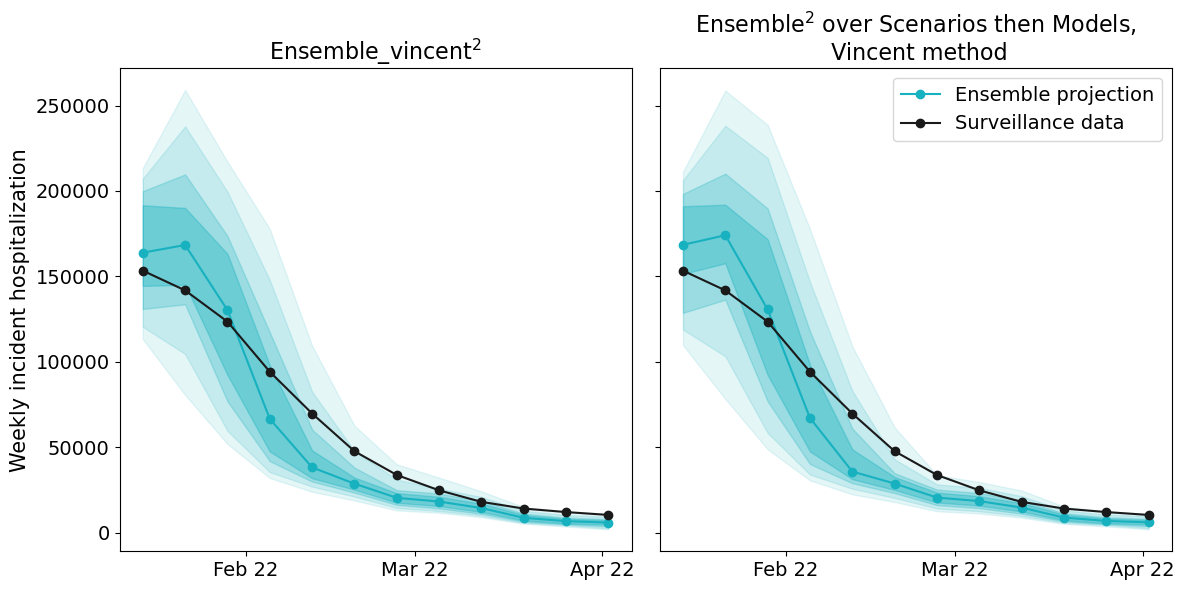

In [58]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)

#model = "Ensemble"
model = 'Ensemble'
rd=17
s=1
for predictions in [ens2, medens]:
    plt.subplot(1,2,s)
    #predictions = pred
    

    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


    incidence = True
    target = 'hosp'
    target_location = 'US'

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                                (observations['date'] <= pd.to_datetime(end_week.enddate()))]



    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

    predictions = predictions[predictions.location == target_location]
    #predictions = predictions[(predictions['target'].isin(target_prediction_list))]



    t = predictions.target_end_date.unique()
    intervals = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = list(predictions[predictions['quantile']==q_low]['value'])
        pred_upp = list(predictions[predictions['quantile']==q_upp]['value'])
        #pred_low = list(predictions.groupby('target_end_date')['value'].quantile(q_low))
        #pred_upp = list(predictions.groupby('target_end_date')['value'].quantile(q_upp))
        
        zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_low, pred_upp)
        sorted_zipped = sorted(zipped)
        ts, predlow, predup = zip(*sorted_zipped)
        axes[s-1].fill_between(ts,predup,predlow, color='#17B1BF', alpha=alpha)

    #point estimate
   # pred_point = list(predictions.groupby('target_end_date')['value'].quantile(.5))
    pred_point = list(predictions[predictions['quantile']==.5]['value'])
    zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_point)
    sorted_zipped = sorted(zipped)
    ts, predpt = zip(*sorted_zipped)
    if len(predpt) > 0:
        axes[s-1].plot(ts,predpt,'-o',color='#17B1BF', label = 'Ensemble projection')

    #plot surveillance
    axes[s-1].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    #set x axis
    set_date_axis_fmt(axes[s-1])


    #set y axis 
    #axes[0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}")
    
    
    if s==1:
        plt.title(r'Ensemble_vincent$^2$', fontsize=16)
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}",fontsize=15)
        
    else:
        plt.title('Ensemble$^2$ over Scenarios then Models,'+'\n Vincent method', fontsize=16)
             
    s+=1

axes[0].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)    
    
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('./rebuttal_figs/ensembleorder_envelop.pdf')

In [110]:
preds = predictions_rd12[predictions_rd12.Model.isin(['JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha',
       'UVA-adaptive', 'UNCC-hierbin', 'UVA-EpiHiper'])]


test = ScenarioEnsemble(df=preds[preds.scenario_id =='A-2022-01-09'], obsdf=obsdf, 
                        target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
ensmodel = test.get_scenarioensemble()

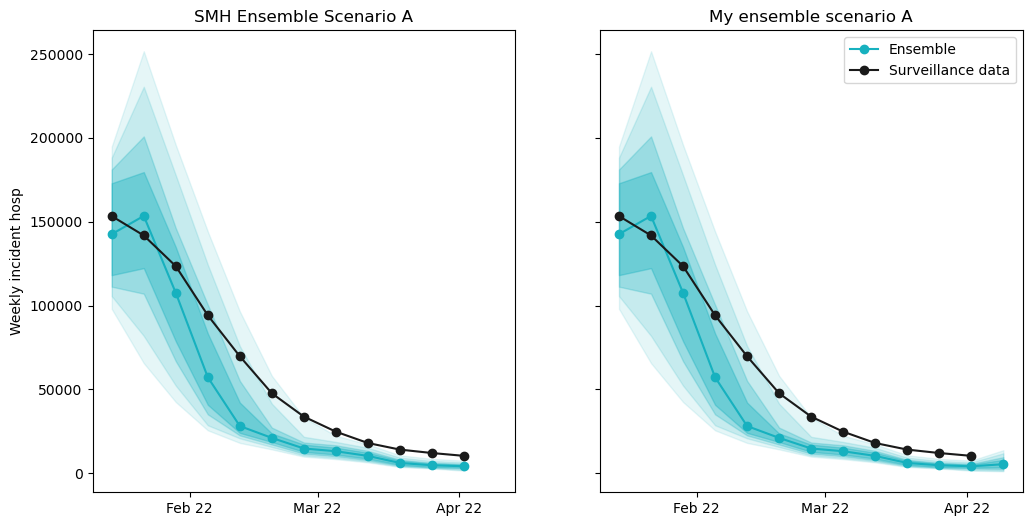

In [188]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)

model = "Ensemble"
#model = 'Ensemble'
rd=12
s=1

predictionsensemble = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

predictionsensemble= predictionsensemble[(predictionsensemble.scenario_id == 'A-2022-01-09') & \
                                        (predictionsensemble.target.str.contains('inc hosp'))]
predictionsensemble.drop(predictionsensemble[predictionsensemble.type == 'point'].index, inplace=True)


for predictions in [predictionsensemble, ensmodel]:
#for predictions in [predictionsensemble]:
    plt.subplot(1,2,s)
    #predictions = pred
    

    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


    incidence = True
    target = 'hosp'
    target_location = 'US'

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                                (observations['date'] <= pd.to_datetime(end_week.enddate()))]



    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

    predictions = predictions[predictions.location == target_location]
    #predictions = predictions[(predictions['target'].isin(target_prediction_list))]



    t = predictions.target_end_date.unique()
    t.sort()

    intervals = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
    #intervals = [(.35, .65)]
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = list(predictions[predictions['quantile']==q_low]['value'])
        pred_upp = list(predictions[predictions['quantile']==q_upp]['value'])
        #pred_low = list(predictions.groupby('target_end_date')['value'].quantile(q_low))
        #pred_upp = list(predictions.groupby('target_end_date')['value'].quantile(q_upp))
        
        zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_low, pred_upp)
        sorted_zipped = sorted(zipped)
        ts, predlow, predup = zip(*sorted_zipped)
        axes[s-1].fill_between(ts,predup,predlow, color='#17B1BF', alpha=alpha)

    #point estimate
   # pred_point = list(predictions.groupby('target_end_date')['value'].quantile(.5))
    pred_point = list(predictions[predictions['quantile']==.5]['value'])
    zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_point)
    sorted_zipped = sorted(zipped)
    ts, predpt = zip(*sorted_zipped)
    if len(predpt) > 0:
        axes[s-1].plot(ts,predpt,'-o',color='#17B1BF', label = model)

    #plot surveillance
    axes[s-1].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    #set x axis
    set_date_axis_fmt(axes[s-1])


    #set y axis 
    axes[0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
    
    if s==1:
        plt.title('SMH Ensemble Scenario A')
        
    else:
        plt.title('My ensemble scenario A')
             
    s+=1

plt.legend()

# LOP

In [25]:
def prob_avg_ensemble(predictions_list):

    target_list = list(predictions_list[0].target.unique())

    interpvalsdf = pd.DataFrame(columns=['target', 'interpvals'])
    for wk in target_list:

        interpvals = []
        for i in range(len(predictions_list)):
            s = predictions_list[i][predictions_list[i]['target'] ==wk ]
            vals = list(s['value'])
            for j in range(len(vals)):
                interpvals.append(vals[j])
            
        new_row = {'target':wk, 'interpvals':interpvals}
 
        interpvalsdf = interpvalsdf.append(new_row, ignore_index=True)
    
    interpresults = pd.DataFrame(columns=['scenario_letter', 'quantile_val','xvalue', 'target'])

    for wk in target_list:

        for i in range(len(predictions_list)):
            interpvals = list(interpvalsdf[interpvalsdf['target']==wk].interpvals)[0]
    
            sample = predictions_list[i][predictions_list[i].target == wk ]
    
            sample = sample[sample['type']=='quantile']
    
            quantiles = list(sample['quantile'])
            vals = list(sample['value'])

            a = zip(vals, quantiles)
            a=list(a)
            res = sorted(a, key = lambda x: x[1])
            vals, quants = list(zip(*res))

            vals = list(vals)
            quants = list(quants)
    
            y = np.interp(interpvals, vals, quants)
    
    
            a = zip(interpvals, y)
            a=list(a)
            res = sorted(a, key = lambda x: x[1])
            interpvals, y = list(zip(*res))
    
    
            letter = list(sample.scenario_letter.unique())[0]
            y = list(y)
            interpvals = list(interpvals)
            for i in range(len(y)):
                qval = y[i]
                xval = interpvals[i]
                new_row = {'scenario_letter':letter, 'quantile_val':qval,'xvalue':xval, 'target':wk}
 
                interpresults = interpresults.append(new_row, ignore_index=True)

    df2 = interpresults.groupby(['target', 'xvalue'])['quantile_val'].mean()
    allxvals = list(df2.index)

    probavg = pd.DataFrame(columns=['xval', 'avg_quant', 'target'])

    for i in allxvals:
        avgquant = df2[i]
        targ = i[0]
        val = i[1]
        new_row = {'xval':val, 'avg_quant':avgquant, 'target':targ}
 
        probavg = probavg.append(new_row, ignore_index=True)
    
    
    
    probavg_ret = pd.DataFrame(columns=['quantile','value', 'target', 'target_end_date'])
    ind = 0

    enddates = predictions_list[0].target_end_date.unique()
    for wk in target_list:
        enddate = enddates[ind]
        ind+=1
        ret_quants = list(predictions_list[0][predictions_list[0].target =='1 wk ahead inc ' + str(target)]['quantile'].unique())
        curquants = list(probavg[probavg['target']==wk]['avg_quant'])
        curxs = list(probavg[probavg['target']==wk]['xval'])
        yret = np.interp(ret_quants, curquants, curxs)
    
        yret = list(yret)
    
        for i in range(len(yret)):
            new_row = {'quantile':ret_quants[i],'value':yret[i], 'target':wk, 'target_end_date':enddate}
 
            probavg_ret = probavg_ret.append(new_row, ignore_index=True)
    
   # probavg_ret = Predictions(probavg_ret, t_col='target_end_date')
    
    return probavg_ret


In [26]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha',
       'UVA-adaptive', 'UNCC-hierbin', 'UVA-EpiHiper']:
    df = predictions_rd12[predictions_rd12.Model == model]
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])

dfall['scenario_letter'] = dfall.Model

In [27]:
preds = predictions_rd12[predictions_rd12.Model == 'MOBS_NEU-GLEAM_COVID']

wksahead = preds[['target', 'target_end_date']].drop_duplicates()

wksahead = wksahead[wksahead.target.str.contains('inc hosp')]

In [28]:
dfall = pd.merge(dfall, wksahead, on='target_end_date')
dfall['target'] = dfall['target_y'] 
dfall = dfall.drop(columns=['target_x', 'target_y'])


In [29]:
enslopall = pd.DataFrame()
for loc in dfall.location.unique():
    df = dfall[dfall.location == loc]

    enslop = prob_avg_ensemble([df[(df.Model==i)] for i in df.Model.unique()])
    enslop['location'] = loc
    
    enslopall = pd.concat([enslopall, enslop])

In [222]:
enslopall

,quantile,value,target,target_end_date,location
0,NaN,NaN,1 wk ahead inc hosp,2022-01-15,02
1,0.990,1041.397333,1 wk ahead inc hosp,2022-01-15,02
2,0.975,839.948996,1 wk ahead inc hosp,2022-01-15,02
3,0.950,731.502577,1 wk ahead inc hosp,2022-01-15,02
4,0.900,551.408949,1 wk ahead inc hosp,2022-01-15,02
...,...,...,...,...,...
307,0.200,0.000000,12 wk ahead inc hosp,2022-04-02,60
308,0.250,0.000000,12 wk ahead inc hosp,2022-04-02,60
309,0.300,0.000000,12 wk ahead inc hosp,2022-04-02,60
310,0.350,0.000000,12 wk ahead inc hosp,2022-04-02,60


In [30]:
for model in ['Ensemble_LOP_untrimmed']:
    df = predictions_rd12[predictions_rd12.Model == model]
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    ens2lop = test.get_scenarioensemble()
    ens2lop['Model'] = model

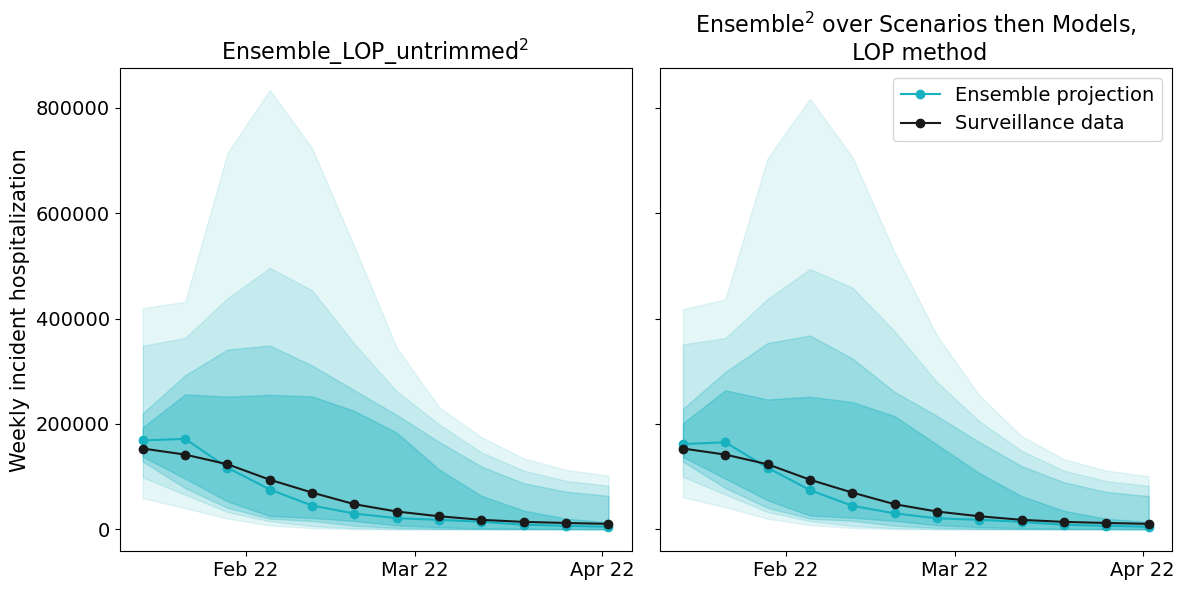

In [59]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)

#model = "Ensemble"
model = 'Ensemble_LOP_untrimmed'
rd=17
s=1
for predictions in [enslopall, ens2lop]:
    plt.subplot(1,2,s)
    #predictions = pred
    

    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


    incidence = True
    target = 'hosp'
    target_location = 'US'

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                                (observations['date'] <= pd.to_datetime(end_week.enddate()))]



    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

    predictions = predictions[predictions.location == target_location]
    #predictions = predictions[(predictions['target'].isin(target_prediction_list))]



    t = predictions.target_end_date.unique()

    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = list(predictions[predictions['quantile']==q_low]['value'])
        pred_upp = list(predictions[predictions['quantile']==q_upp]['value'])
        #pred_low = list(predictions.groupby('target_end_date')['value'].quantile(q_low))
        #pred_upp = list(predictions.groupby('target_end_date')['value'].quantile(q_upp))
        
        zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_low, pred_upp)
        sorted_zipped = sorted(zipped)
        ts, predlow, predup = zip(*sorted_zipped)
        axes[s-1].fill_between(ts,predup,predlow, color='#17B1BF', alpha=alpha)

    #point estimate
   # pred_point = list(predictions.groupby('target_end_date')['value'].quantile(.5))
    pred_point = list(predictions[predictions['quantile']==.5]['value'])
    zipped = zip(list(predictions[predictions['quantile']==q_low]['target_end_date']), pred_point)
    sorted_zipped = sorted(zipped)
    ts, predpt = zip(*sorted_zipped)
    if len(predpt) > 0:
        axes[s-1].plot(ts,predpt,'-o',color='#17B1BF', label = 'Ensemble projection')

    #plot surveillance
    axes[s-1].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    #set x axis
    set_date_axis_fmt(axes[s-1])


    #set y axis 
    #axes[0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
    
    if s==1:
        plt.title(model+r'$^2$', fontsize=16)
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}", fontsize=15)
        
    else:
        plt.title('Ensemble$^2$ over Scenarios then Models,'+'\n LOP method', fontsize=16)
             
    s+=1
    
axes[0].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14) 

plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('./rebuttal_figs/ensembleorder_envelopLOP.pdf')

# run for all rounds and targets

In [230]:
rd = 5
start_week = Week(2021,17)
end_week = Week(2021,43)
max_date = datetime.datetime(2021, 6, 19)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd5 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd5 = pd.concat([predictions_rd5, predictions])

In [231]:
rd = 6
start_week = Week(2021,22)
end_week = Week(2021,47)
max_date = datetime.datetime(2021, 12, 18)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd6 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd6 = pd.concat([predictions_rd6, predictions])

In [232]:
rd = 7
start_week = Week(2021,27)
end_week = Week(2021,52)
max_date = datetime.datetime(2021, 12, 18)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd7 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd7 = pd.concat([predictions_rd7, predictions])

In [233]:
rd = 9
start_week = Week(2021,37)
end_week = Week(2022,9)
max_date = datetime.datetime(2021, 12, 18)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd9 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd9 = pd.concat([predictions_rd9, predictions])

In [234]:
rd = 11
start_week = Week(2021,51)
end_week = Week(2022, 10)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd11 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd11 = pd.concat([predictions_rd11, predictions])

In [235]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022, 13)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd12 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd12 = pd.concat([predictions_rd12, predictions])

In [236]:
rd = 13
start_week = Week(2022,11)
end_week = Week(2023, 11)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd13 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd13 = pd.concat([predictions_rd13, predictions])

In [377]:
rd = 14
start_week = Week(2022,23)
end_week = Week(2023, 23)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd14 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd14 = pd.concat([predictions_rd14, predictions])

In [381]:
predictions_rd14.replace("1", "01", inplace=True)
predictions_rd14.replace("2", "02", inplace=True)
predictions_rd14.replace("5", "05", inplace=True)
predictions_rd14.replace("8", "08", inplace=True)
predictions_rd14.replace("9", "09", inplace=True)
predictions_rd14.replace("4", "04", inplace=True)
predictions_rd14.replace("6", "06", inplace=True)

In [238]:
rd = 15
start_week = Week(2022,31)
end_week = Week(2023, 18)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd15 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd15 = pd.concat([predictions_rd15, predictions])

In [239]:
rd = 16
start_week = Week(2022,44)
end_week = Week(2023, 17)
#max_date = datetime.datetime(2021, 12, 21)
#models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed"]

models = modelsall

predictions_rd16 = pd.DataFrame()
for model in models:
    fil = Path(f'./dat/{model}_rd{rd}.pq')
    if fil.is_file():
    
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

        predictions['Model'] = model
    
        predictions_rd16 = pd.concat([predictions_rd16, predictions])

In [407]:
wis_all = pd.DataFrame()

incidence = True
#target = 'hosp'

models = ['CU-AGE-ST', 'JHU_IDD-CovidSP', 'Karlen-pypm',
          'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha', 'UVA-adaptive', 'JHUAPL-Bucky', 'UNCC-hierbin', 'UVA-EpiHiper']


startdates = [ Week(2021,18), Week(2021,22), Week(2021,27), Week(2021,37), Week(2021,51),
             Week(2022,2), Week(2022,11), Week(2022,23), Week(2022,31), Week(2022,44)]


enddates = [ Week(2021,43), Week(2021,47), Week(2021,52), Week(2022,9),  Week(2022, 10),
           Week(2022, 13), Week(2023, 11), Week(2023, 23), Week(2023, 18), Week(2023, 17)]


predsall = [predictions_rd5, predictions_rd6, predictions_rd7, predictions_rd9, 
           predictions_rd11, predictions_rd12, predictions_rd13, predictions_rd14, predictions_rd15, predictions_rd16]
rds = [5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]


for target in ['hosp', 'death', 'case']:

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death'
    else:
        target_obs = target
    obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")


    i=0

    for predictions in predsall:
    
        start_week = startdates[i]
        end_week = enddates[i]
        rd = rds[i]

        if rd in [4, 5]:
            max_date = datetime.datetime(2021, 6, 19)
        elif rd in [6,7,8,9]:
            max_date = datetime.datetime(2021, 12, 18)
        elif rd in [13,14,15,16]:
            max_date = datetime.datetime(2023, 3, 4)
        else:
            max_date = None

        dfall = pd.DataFrame()
        for model in models:
            if model in predictions.Model.unique():
                if (target=='death') & (model=='UVA-adaptive') & (rd in [15, 16]):
                    continue
                df = predictions[predictions.Model == model]
                test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = max_date, 
                                        start_week = start_week, end_week = end_week)
                medens = test.get_scenarioensemble()
                medens['Model'] = model

                dfall = pd.concat([dfall, medens])

        dfall['scenario_id'] = dfall.Model

        preds = predictions[predictions.Model == 'MOBS_NEU-GLEAM_COVID']

        wksahead = preds[['target', 'target_end_date']].drop_duplicates()

        wksahead = wksahead[wksahead.target.str.contains('inc '+ target)]

        dfall = pd.merge(dfall, wksahead, on='target_end_date')
        dfall['target'] = dfall['target_y'] 
        dfall = dfall.drop(columns=['target_x', 'target_y'])

        test = ScenarioEnsemble(df=dfall, obsdf=obsdf, target=target, incidence = True, max_date = max_date, 
                                        start_week = start_week, end_week = end_week)
        medens = test.get_scenarioensemble()
        medens['Model'] = 'Scenario-model-ensemble'
        

        for model in ['Ensemble']:
            df = predictions[predictions.Model == model]
            test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = max_date, 
                                    start_week = start_week, end_week = end_week)
            ens2 = test.get_scenarioensemble()
            ens2['Model'] = model
            
        # calculate WIS scores for both
        
        
        test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = medens, 
                           target=target, incidence = True, max_date = max_date, 
                                    start_week = start_week, end_week = end_week)
        wis_reverse = test2.organize_average_scores(want_scores=['wis_mean'])
                
            
        if len(wis_reverse) == 0:
            break
        

        ens2['Model'] = 'Regular-ensemble2'

        test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = ens2, 
                       target = target, incidence = True, max_date = max_date, 
                                start_week = start_week, end_week = end_week)
        wis_regular = test2.organize_average_scores(want_scores=['wis_mean'])    


        wis_scores = pd.concat([wis_reverse, wis_regular])
        wis_scores['Round'] = rd
        wis_scores['target'] = target

        wis_all = pd.concat([wis_all, wis_scores])

        i += 1

[ 88.43249962  90.86861479  20.83926574  12.03006032  10.72377409
  14.34563138  28.52946752  34.67994831  42.48786804  56.13550765
  50.30728095  51.35348666  61.96823166  72.29002239  88.77032229
 104.98691272  78.78618736  42.59120925  40.83662656  67.78654104
  33.67051649  -7.68229763 -30.97307914  16.23526505  28.8636748
  35.25216336  97.15349662 105.65139599 116.85868908  94.3251598
  85.45618055 144.00360737  67.225       65.4         39.225
  45.45        74.55        48.42226667  84.7474      57.57583861
 105.9542027  107.12081049 133.4294065  122.57759285 114.60692726
 106.96110957  96.22490059  90.50584997 102.57748726 129.8844276
 165.96033841]
something went wrong, upper quantile bigger than lower quantile
17
[ 49.13205088  13.47564752 -11.33009155   7.40782229  14.33733237
  12.03584072  29.53481523  39.96336661  38.40372757  33.86955946
  33.37787425  35.37585802  40.87524859  66.14116725 100.36149094
  53.46168065 279.22468217  80.97552902  80.95512916  40.02712345
  

[ 1.93280911  6.05360441  3.55163971  3.96502895  2.60731001  5.06206398
  4.62862891  4.33376853  4.21800755  2.8661276   4.05133796  6.61914289
  7.35667787  8.01513239  7.66171871  3.63174895  1.85390108  0.95513941
  0.67603296  2.34957258  1.55789429  1.67476603  2.5034728   5.76744465
  4.39336401  6.25009953  8.8460702   4.33682303 -0.21102336  6.06145566
  9.21243105  9.54419369 11.2847327   9.57696521  8.0541587  11.22925811
 12.35082178 10.68388499  5.08312345  5.22084035  5.70593117  6.71842043
  5.3096435   3.94159681  5.36351825  6.29378039  4.79505411  6.6532126
  4.75913349  4.68730548  6.12973381]
something went wrong, upper quantile bigger than lower quantile
47
[ 0.45        0.35        0.05        0.05        0.39720944  0.4585401
  0.49961476  0.46761565  0.39881245  0.53355892  0.65297946  0.63263246
  0.62367376  0.73686708  0.85179784  0.6845979   0.65846599  0.66162552
  0.49975467  0.26238515  0.19304646 -0.00524968  0.04930045  0.07248074
  0.1702934   0.20087

In [408]:
wis_all

,Model,location,wis_mean,Round,target
0,Scenario-model-ensemble,02,10.340690,5,hosp
1,Scenario-model-ensemble,01,36.755981,5,hosp
2,Scenario-model-ensemble,05,99.323181,5,hosp
3,Scenario-model-ensemble,04,37.463437,5,hosp
4,Scenario-model-ensemble,06,352.641768,5,hosp
...,...,...,...,...,...
47,Regular-ensemble2,53,662.454389,16,case
48,Regular-ensemble2,54,493.089708,16,case
49,Regular-ensemble2,55,760.506024,16,case
50,Regular-ensemble2,56,154.210447,16,case


In [410]:
wis_all.to_pickle(f'rebuttal_wis_ensembleorder_1031_2.pkl')  

In [440]:
wis_all = pd.read_pickle('rebuttal_wis_ensembleorder_1031_2.pkl')
wis_reg = wis_all[wis_all.Model == 'Regular-ensemble2']
wis_back = wis_all[wis_all.Model == 'Scenario-model-ensemble']

wis_ratio = wis_reg.merge(wis_back, how='inner', on = ['location', 'Round', 'target'])

wis_ratio['wis_ratio'] = wis_ratio['wis_mean_x'] / wis_ratio['wis_mean_y']

In [412]:
wis_ratio

,Model_x,location,wis_mean_x,Round,target,Model_y,wis_mean_y,wis_ratio
0,Regular-ensemble2,01,39.918375,5,hosp,Scenario-model-ensemble,36.755981,1.086038
1,Regular-ensemble2,02,8.593074,5,hosp,Scenario-model-ensemble,10.340690,0.830996
2,Regular-ensemble2,04,39.365499,5,hosp,Scenario-model-ensemble,37.463437,1.050771
3,Regular-ensemble2,05,106.170892,5,hosp,Scenario-model-ensemble,99.323181,1.068944
4,Regular-ensemble2,06,332.730291,5,hosp,Scenario-model-ensemble,352.641768,0.943536
...,...,...,...,...,...,...,...,...
1537,Regular-ensemble2,53,662.454389,16,case,Scenario-model-ensemble,773.583817,0.856345
1538,Regular-ensemble2,54,493.089708,16,case,Scenario-model-ensemble,561.346055,0.878406
1539,Regular-ensemble2,55,760.506024,16,case,Scenario-model-ensemble,1223.332468,0.621667
1540,Regular-ensemble2,56,154.210447,16,case,Scenario-model-ensemble,156.485973,0.985459


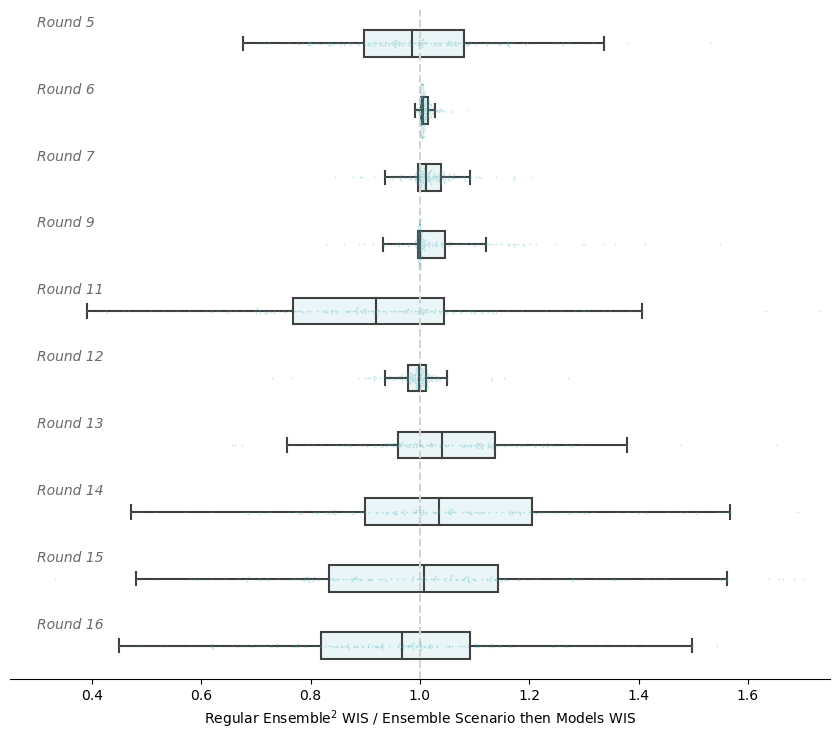

In [427]:
fig = plt.figure(figsize=(8.5,7.5))
ax = fig.add_subplot(111)
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


my_order = wis_ratio.groupby(by=['Round'])['Round'].median().sort_values(ascending=True).index
g = sns.boxplot(x='wis_ratio', y='Round', data=wis_ratio,order=my_order, color = '#17B1BF',width=.4, orient='h',
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))

    
sns.swarmplot(x='wis_ratio', y='Round', data=wis_ratio,order=my_order,
              color = "#49AFB7",alpha = .35,size=1.25, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

g.set(xlabel=r'Regular Ensemble$^2$ WIS / Ensemble Scenario then Models WIS')


plt.xlim([0.25,1.75]) # cuts off some outliers

a = 0
for mod in list(my_order):
    plt.text(0.3,a-.25, 'Round '+ str(mod), fontsize=10, style='italic', color='dimgray')
    a+=1
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)



#plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
plt.tight_layout()
plt.savefig('wisratio_compareorder.pdf')
plt.show()


In [ ]:
# LOP method

In [429]:
wis_all = pd.DataFrame()

incidence = True
#target = 'hosp'

models = ['CU-AGE-ST', 'JHU_IDD-CovidSP', 'Karlen-pypm',
          'MOBS_NEU-GLEAM_COVID', 'USC-SIkJalpha', 'UVA-adaptive', 'JHUAPL-Bucky', 'UNCC-hierbin', 'UVA-EpiHiper']


startdates = [ Week(2021,18), Week(2021,22), Week(2021,27), Week(2021,37), Week(2021,51),
             Week(2022,2), Week(2022,11), Week(2022,23), Week(2022,31), Week(2022,44)]


enddates = [ Week(2021,43), Week(2021,47), Week(2021,52), Week(2022,9),  Week(2022, 10),
           Week(2022, 13), Week(2023, 11), Week(2023, 23), Week(2023, 18), Week(2023, 17)]


predsall = [predictions_rd5, predictions_rd6, predictions_rd7, predictions_rd9, 
           predictions_rd11, predictions_rd12, predictions_rd13, predictions_rd14, predictions_rd15, predictions_rd16]
rds = [5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]


for target in ['hosp', 'death', 'case']:

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death'
    else:
        target_obs = target
    obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")


    i=0

    for predictions in predsall:
    
        start_week = startdates[i]
        end_week = enddates[i]
        rd = rds[i]

        if rd in [4, 5]:
            max_date = datetime.datetime(2021, 6, 19)
        elif rd in [6,7,8,9]:
            max_date = datetime.datetime(2021, 12, 18)
        elif rd in [13,14,15,16]:
            max_date = datetime.datetime(2023, 3, 4)
        else:
            max_date = None

        dfall = pd.DataFrame()
        for model in models:
            if model in predictions.Model.unique():
                if (target=='death') & (model=='UVA-adaptive') & (rd in [15, 16]):
                    continue
                df = predictions[predictions.Model == model]
                test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = max_date, 
                                        start_week = start_week, end_week = end_week)
                medens = test.get_scenarioensemble()
                medens['Model'] = model

                dfall = pd.concat([dfall, medens])

        dfall['scenario_letter'] = dfall.Model

        preds = predictions[predictions.Model == 'MOBS_NEU-GLEAM_COVID']

        wksahead = preds[['target', 'target_end_date']].drop_duplicates()

        wksahead = wksahead[wksahead.target.str.contains('inc '+ target)]

        dfall = pd.merge(dfall, wksahead, on='target_end_date')
        dfall['target'] = dfall['target_y'] 
        dfall = dfall.drop(columns=['target_x', 'target_y'])

        enslopall = pd.DataFrame()
        for loc in dfall.location.unique():
            df = dfall[dfall.location == loc]

            enslop = prob_avg_ensemble([df[(df.Model==i)] for i in df.Model.unique()])
            enslop['location'] = loc

            enslopall = pd.concat([enslopall, enslop])
        enslopall['Model'] = 'Scenario-model-ensemble'
            
        for model in ['Ensemble_LOP_untrimmed']:
            df = predictions[predictions.Model == model]
            test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = max_date, 
                                    start_week = start_week, end_week = end_week)
            ens2 = test.get_scenarioensemble()
            ens2['Model'] = model
            
        # calculate WIS scores for both
        
        
        test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = enslopall, 
                           target=target, incidence = True, max_date = max_date, 
                                    start_week = start_week, end_week = end_week)
        wis_reverse = test2.organize_average_scores(want_scores=['wis_mean'])
                
            
        if len(wis_reverse) == 0:
            break
        

        ens2['Model'] = 'Regular-ensemble2'

        test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = ens2, 
                       target = target, incidence = True, max_date = max_date, 
                                start_week = start_week, end_week = end_week)
        wis_regular = test2.organize_average_scores(want_scores=['wis_mean'])    


        wis_scores = pd.concat([wis_reverse, wis_regular])
        wis_scores['Round'] = rd
        wis_scores['target'] = target

        wis_all = pd.concat([wis_all, wis_scores])

        i += 1

In [432]:
wis_all.to_pickle(f'rebuttal_wis_ensembleorderLOP_111.pkl')  

In [41]:
wis_all = pd.read_pickle('rebuttal_wis_ensembleorder_1031_2.pkl')
wis_reg = wis_all[wis_all.Model == 'Regular-ensemble2']
wis_reg['Model'] = 'Regular-ensemble2LOP'
wis_back = wis_all[wis_all.Model == 'Scenario-model-ensemble']
wis_back['Model'] = 'Scenario-model-ensembleLOP'

wis_ratio = wis_reg.merge(wis_back, how='inner', on = ['location', 'Round', 'target'])

wis_ratio['wis_ratio'] = wis_ratio['wis_mean_x'] / wis_ratio['wis_mean_y']

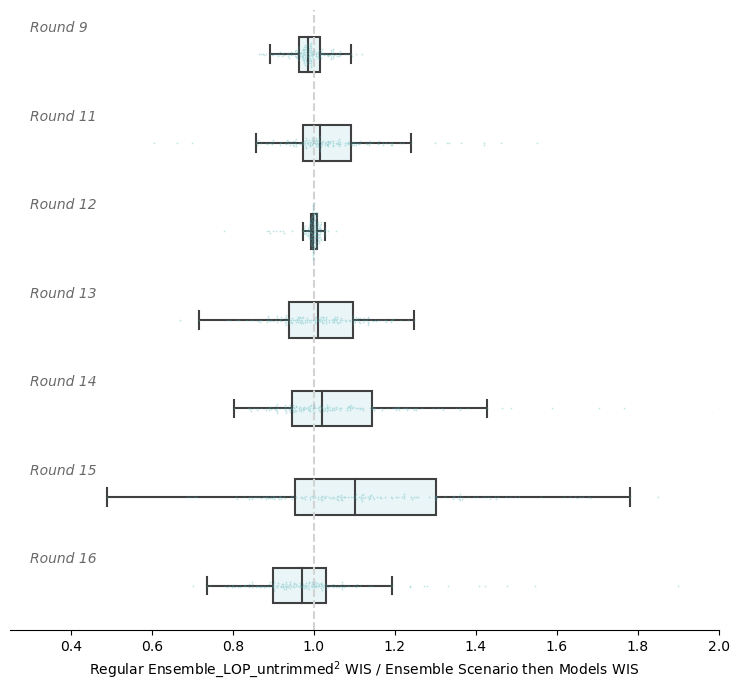

In [438]:
fig = plt.figure(figsize=(7.5,7))
ax = fig.add_subplot(111)
rds = [ 9, 11, 12, 13, 14 ,15, 16]

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


my_order = wis_ratio.groupby(by=['Round'])['Round'].median().sort_values(ascending=True).index
g = sns.boxplot(x='wis_ratio', y='Round', data=wis_ratio,order=my_order, color = '#17B1BF',width=.4, orient='h',
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))

    
sns.swarmplot(x='wis_ratio', y='Round', data=wis_ratio,order=my_order,
              color = "#49AFB7",alpha = .35,size=1.25, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

g.set(xlabel=r'Regular Ensemble_LOP_untrimmed$^2$ WIS / Ensemble Scenario then Models WIS')


plt.xlim([0.25,2]) # cuts off some outliers

a = 0
for mod in list(my_order):
    plt.text(0.3,a-.25, 'Round '+ str(mod), fontsize=10, style='italic', color='dimgray')
    a+=1
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)



#plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
plt.tight_layout()
plt.savefig('wisratio_compareorderLOP.pdf')
plt.show()


In [446]:
wis_ratiolop

,Model_x,location,wis_mean_x,Round,target,Model_y,wis_mean_y,wis_ratio
0,Regular-ensemble2LOP,02,37.257093,9,hosp,Scenario-model-ensembleLOP,39.733145,0.937683
1,Regular-ensemble2LOP,01,304.904861,9,hosp,Scenario-model-ensembleLOP,312.066510,0.977051
2,Regular-ensemble2LOP,05,113.943451,9,hosp,Scenario-model-ensembleLOP,114.654078,0.993802
3,Regular-ensemble2LOP,04,651.350050,9,hosp,Scenario-model-ensembleLOP,648.150107,1.004937
4,Regular-ensemble2LOP,06,658.745728,9,hosp,Scenario-model-ensembleLOP,720.499381,0.914290
...,...,...,...,...,...,...,...,...
1087,Regular-ensemble2LOP,53,1433.905347,16,case,Scenario-model-ensembleLOP,1501.838121,0.954767
1088,Regular-ensemble2LOP,54,659.992493,16,case,Scenario-model-ensembleLOP,733.841685,0.899366
1089,Regular-ensemble2LOP,55,2002.084190,16,case,Scenario-model-ensembleLOP,1941.124407,1.031404
1090,Regular-ensemble2LOP,56,179.199115,16,case,Scenario-model-ensembleLOP,178.974055,1.001257


In [447]:
wis_ratio

,Model_x,location,wis_mean_x,Round,target,Model_y,wis_mean_y,wis_ratio
0,Regular-ensemble2,01,39.918375,5,hosp,Scenario-model-ensemble,36.755981,1.086038
1,Regular-ensemble2,02,8.593074,5,hosp,Scenario-model-ensemble,10.340690,0.830996
2,Regular-ensemble2,04,39.365499,5,hosp,Scenario-model-ensemble,37.463437,1.050771
3,Regular-ensemble2,05,106.170892,5,hosp,Scenario-model-ensemble,99.323181,1.068944
4,Regular-ensemble2,06,332.730291,5,hosp,Scenario-model-ensemble,352.641768,0.943536
...,...,...,...,...,...,...,...,...
1537,Regular-ensemble2,53,662.454389,16,case,Scenario-model-ensemble,773.583817,0.856345
1538,Regular-ensemble2,54,493.089708,16,case,Scenario-model-ensemble,561.346055,0.878406
1539,Regular-ensemble2,55,760.506024,16,case,Scenario-model-ensemble,1223.332468,0.621667
1540,Regular-ensemble2,56,154.210447,16,case,Scenario-model-ensemble,156.485973,0.985459


In [42]:
ordertable= pd.DataFrame(columns=['Round', 'Median WIS ratio of Vincent method (90% CI)',
                                  'Median WIS ratio of LOP method (90% CI)'])

rds = [5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]

for rd in rds:

    medWIS = wis_ratio[wis_ratio.Round == rd].wis_ratio.median()
    q75wis, q25wis = np.percentile(wis_ratio[wis_ratio.Round == rd]['wis_ratio'], [95 ,5])
    
    if rd >= 9:
    
        medWISLOP = wis_ratiolop[wis_ratiolop.Round == rd].wis_ratio.median()
        q75wislop, q25wislop = np.percentile(wis_ratiolop[wis_ratiolop.Round == rd]['wis_ratio'], [95 ,5])
    else:
        medWISLOP = 0
        q75wislop = 0
        q25wislop = 0
        

    
    new_row = {'Round':rd, 'Median WIS ratio of Vincent method (90% CI)':str(round(medWIS,2)) + ' '+str((round(q25wis,2), round(q75wis,2))) ,
               'Median WIS ratio of LOP method (90% CI)':str(round(medWISLOP,2)) + ' '+ str((round(q25wislop,2), round(q75wislop,2))) }

    ordertable = ordertable.append(new_row, ignore_index=True)
    

In [43]:
ordertable

,Round,Median WIS ratio of Vincent method (90% CI),Median WIS ratio of LOP method (90% CI)
0,5,"0.99 (0.78, 1.25)","0 (0, 0)"
1,6,"1.01 (1.0, 1.03)","0 (0, 0)"
2,7,"1.01 (0.95, 1.09)","0 (0, 0)"
3,9,"1.0 (0.95, 1.2)","0.99 (0.9, 1.06)"
4,11,"0.92 (0.57, 1.3)","1.02 (0.88, 1.26)"
5,12,"1.0 (0.92, 1.04)","1.0 (0.93, 1.02)"
6,13,"1.04 (0.84, 1.28)","1.01 (0.85, 1.18)"
7,14,"1.03 (0.7, 1.51)","1.02 (0.87, 1.37)"
8,15,"1.01 (0.63, 1.56)","1.1 (0.84, 1.65)"
9,16,"0.97 (0.62, 1.34)","0.97 (0.8, 1.25)"


In [44]:
ordertable.style.set_table_styles([dict(selector="th",props=[('max-width', '170px')])])


,Round,Median WIS ratio of Vincent method (90% CI),Median WIS ratio of LOP method (90% CI)
0,5,"0.99 (0.78, 1.25)","0 (0, 0)"
1,6,"1.01 (1.0, 1.03)","0 (0, 0)"
2,7,"1.01 (0.95, 1.09)","0 (0, 0)"
3,9,"1.0 (0.95, 1.2)","0.99 (0.9, 1.06)"
4,11,"0.92 (0.57, 1.3)","1.02 (0.88, 1.26)"
5,12,"1.0 (0.92, 1.04)","1.0 (0.93, 1.02)"
6,13,"1.04 (0.84, 1.28)","1.01 (0.85, 1.18)"
7,14,"1.03 (0.7, 1.51)","1.02 (0.87, 1.37)"
8,15,"1.01 (0.63, 1.56)","1.1 (0.84, 1.65)"
9,16,"0.97 (0.62, 1.34)","0.97 (0.8, 1.25)"


In [45]:
print(ordertable.round(2).to_latex(index=False))

\begin{tabular}{lll}
\toprule
Round & Median WIS ratio of Vincent method (90\% CI) & Median WIS ratio of LOP method (90\% CI) \\
\midrule
    5 &                           0.99 (0.78, 1.25) &                                0 (0, 0) \\
    6 &                            1.01 (1.0, 1.03) &                                0 (0, 0) \\
    7 &                           1.01 (0.95, 1.09) &                                0 (0, 0) \\
    9 &                             1.0 (0.95, 1.2) &                        0.99 (0.9, 1.06) \\
   11 &                            0.92 (0.57, 1.3) &                       1.02 (0.88, 1.26) \\
   12 &                            1.0 (0.92, 1.04) &                        1.0 (0.93, 1.02) \\
   13 &                           1.04 (0.84, 1.28) &                       1.01 (0.85, 1.18) \\
   14 &                            1.03 (0.7, 1.51) &                       1.02 (0.87, 1.37) \\
   15 &                           1.01 (0.63, 1.56) &                        1.1 (0.84

# Target-specific figures

In [532]:
class Plots(Scoring):
    # make plots related to performance analysis, scoring, WIS ratios, etc.
    # uses output from score functions so input must be data you want to be scored and plotted
    
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, scoredf, target, incidence, max_date, start_week, end_week)
        
        
    def get_rescaledWIS_boxplot(self):
        # make plot that shows the distribution of rescaled WIS values for all models of interest
        
        df = self.get_rescaled_wis()
        
        df = df.rename(columns= {"wis_scaled":"values","Model":"group"})

        wisnormalldf = df
        
        models = list(wisnormalldf.group.unique())
        allmed = []
        for model in models:
            med = wisnormalldf[wisnormalldf['group']== model]['values'].median()
            allmed.append(med)

        a = zip(models, allmed)
        a=list(a)
        res = sorted(a, key = lambda x: x[1])
        modelorder = list(zip(*res))[0]

        wisnormalldf.group = wisnormalldf.group.astype("category")
        wisnormalldf.group = wisnormalldf.group.cat.set_categories(modelorder)
        wisnormalldf.sort_values(["group"])
        
        wisnormalldf = wisnormalldf[wisnormalldf['values'] >= 0]
        total_groups = wisnormalldf.group.unique().shape[0]
        total_min = 0 #data['values'].min()*-1.2
       # total_max = wisnormalldf['values'].max()*1.2

        fig, ax = plt.subplots(1,1,figsize = (10,8),tight_layout = False)
        
        i=0
        
        g = sns.boxplot(x='group', y='values', data=wisnormalldf,color = '#17B1BF',showfliers=False)

        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))


        sns.swarmplot(x='group', y='values', data=wisnormalldf,color = "#49AFB7",alpha = .5,size=2, orient="v")    

        plt.ylim([0,np.quantile(wisnormalldf['values'], .95)]) # cuts off some outliers
        
        #g.set(ylabel=None)
        #g.set(yticklabels=[])
        #g.set(yticks=[])

        g.set(xlabel='')
        g.set(ylabel=r'Rescaled WIS value')

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)


        plt.show()

        
    def get_wisratio_plot(self,numerator_models, denominator_model, timestamped=False):
        # make plots that shows the distribution of WIS ratios for some numerator models all compared to a single
        # reference denominator model.
        
        allratios = pd.DataFrame()
        for model in numerator_models:
            df = self.get_wis_ratios(numerator_model=model, denominator_model=denominator_model,
                                timestamped=timestamped)
            
            allratios = pd.concat([allratios, df])
            
        fig = plt.figure(figsize=(7,len(numerator_models)*2.5))
        ax = fig.add_subplot(111)

        my_order = allratios.groupby(by=['Model_x'])['wis_ratio'].median().sort_values(ascending=True).index
        g = sns.boxplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order, color = '#17B1BF',width=.4)


        plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))


        sns.swarmplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order,color = "#49AFB7",alpha = .35,size=3,
                      orient="h")    

        g.set(ylabel=None)
        g.set(yticklabels=[])
        g.set(yticks=[])

        g.set(xlabel='WIS ratio')

        #plt.xlim([0,5]) # cuts off some outliers

        a = 0
        for mod in list(my_order):
            plt.text(0.01,a-.25, mod, fontsize=10, style='italic', color='dimgray')
            a+=1

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)



        #plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
        plt.tight_layout()
       #plt.savefig('ensemblecomp_WISvals_rd17.pdf')
        plt.show()
        
        
        
    def get_coverage_plot(self, title):
        # make plot that shows average coverage for a model for different prediction intervals
        modelmap = {'Ensemble':r'Ensemble_vincent$^2$', "Ensemble_LOP":r"Ensemble_LOP$^2$","Ensemble_LOP_untrimmed":r"Ensemble_LOP_untrimmed$^2$",
            "JHU_IDD-CovidSP":'A', "MOBS_NEU-GLEAM_COVID":'B', "UNCC-hierbin":'C', "USC-SIkJalpha":'D', 
            "UVA-EpiHiper":'E', "UVA-adaptive":'F', 'CU-AGE-ST':'G', 'JHUAPL-Bucky':'H', 'Karlen-pypm':'I',
            "NCSU-COVSIM":'J', "NotreDame-FRED":'K', "UTA-ImmunoSEIRS":'L' }
        
        flatui = ['#17B1BF', '#3E603B', '#2539F0','#F3DE8A', '#C38AD8', '#F18C7D', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
        sns.set_palette(flatui)
        marks = ['s', '*', 'v', '+', 'o', 'x', 'D', 'p', '1']
        
        fig, ax = plt.subplots(1,1,figsize = (10,7),tight_layout = False)
        
        
        covers = [10,20,30,40,50,60,70,80,90,95,98]
        covsy = [cv/100 for cv in covers]
        
        df = self.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov', '40_cov', '50_cov',
                                                      '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov'])
        
        
        dfgroup = df.groupby(['Model'], as_index=False).mean()
        
        N = len(dfgroup.Model.unique())
        
        cmap = plt.get_cmap('Set2', N)
        custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
        
        i=0
        for model in dfgroup.Model.unique():
            dfplot = dfgroup[dfgroup.Model == model]
            
            covs = list(dfplot[['10_cov', '20_cov', '30_cov', '40_cov', '50_cov','60_cov', '70_cov', '80_cov', 
                         '90_cov', '95_cov', '98_cov']].values[0])
        

            if model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
                plt.plot(covers, covs,marker = marks[i],markersize=7, label=modelmap[model])
            else:
                plt.plot(covers, covs,marker = marks[i],markersize=6, label=modelmap[model])


        
            # if looping over multiple rounds and things with different observation lengths, would need to average
            # over these so rounds are all weighted the same
            
           # plt.plot(covers, covs, '-o',color=custom_palette[i], label = model)
            
            i += 1
            
        plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
        
        plt.xlabel('Prediction Interval', fontsize=14)
        plt.ylabel('Coverage', fontsize=14)

        plt.text(80, 0.025, 'overconfident', fontsize=14)
        plt.text(50, 0.95, 'underconfident', fontsize=14)
        plt.legend(fontsize=12, frameon=False)
        
        plt.savefig(title+ '.pdf')
        
        plt.show()
        
        
        
    def get_coveragelocation_plot(self, titlename):
        location_mapping = dict()
        for loc in locations['location']:
            location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

       # fig, ax = plt.subplots(1,1,figsize = (10,7),tight_layout = False)
        
        coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                     '80_cov', '90_cov', '95_cov', '98_cov']
        covers = [10,20,30,40,50,60,70,80,90,95,98]
        covsy = [cv/100 for cv in covers]
        
        
        locs = ['06', '48',  '08', '50']
        
        df = self.organize_average_scores(want_scores=coverages)
        
        avgcov = {}
        for l in locs:
            locdf = df[(df['location'] == l) & (df.Model == 'Ensemble_LOP')]

            avgcov[l] = []

            for cv in coverages:
                cov = locdf[cv].mean()
                avgcov[l].append(cov)
                
                
        population = []
        for l in locs:
            population.append(list(locations[locations.location == str(int(l))].population)[0])

        populationsort, locsort = zip(*sorted(zip(population, locs), reverse=True))
        
        
        plt.subplots(2,2,figsize=(7,6), sharey=True, sharex=True)
        i=1
        locsmap = ['6', '48', '8', '50']

        for l in locsort:
            title = locsmap[i-1]
            plt.subplot(2,2,i)

            plt.plot(covers, avgcov[l],'-o', color='#3E603B')
            plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
            plt.title('Location: ' + location_mapping[title], fontsize=14)

            if i in [3,4]:
                plt.xlabel('Prediction interval', fontsize=13)

            if i in [1,3]:
                plt.ylabel('Coverage', fontsize=13)
            i+=1
            #plt.ylabel('Mean Coverage', fontsize=14)


        #plt.suptitle(r'Coverage for all targets, Ensemble_LOP$^2$, round 12 ', fontsize=16)
        
        plt.savefig(titlename+ '.pdf')
        
        plt.show()
        
        
        
    
        

Figure 2

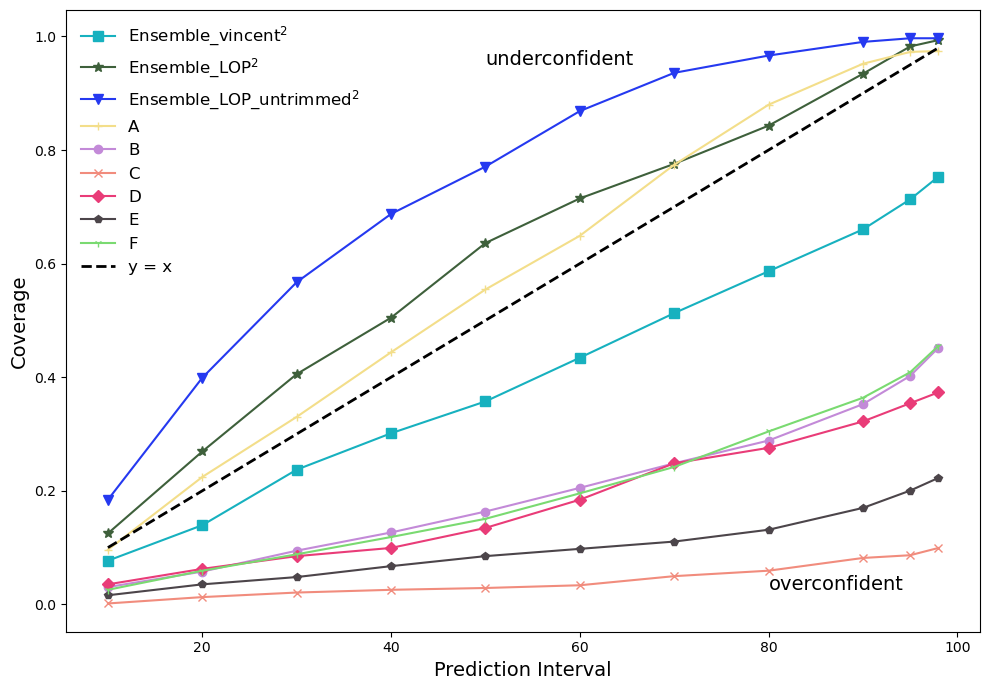

In [510]:
start_week = Week(2022,2)
end_week = Week(2022, 13)

incidence = True
target = 'case'

if target == 'hosp':
    target_obs = 'hospitalization'
elif target == 'death':
    target_obs = 'death'
else:
    target_obs = target

obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['Ensemble', 'Ensemble_LOP','Ensemble_LOP_untrimmed', 'JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 
              'USC-SIkJalpha', 'UVA-adaptive', 'UNCC-hierbin', 'UVA-EpiHiper' ]:
    df = pd.read_parquet(f'./dat/{model}_rd12.pq')
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])
    dfall = dfall[dfall.target_end_date <= pd.to_datetime(end_week.enddate())]


test2 = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target=target, incidence = True, max_date = False, 
                        start_week = start_week, end_week = end_week)
test2.get_coverage_plot(title= 'coverageplot_'+target)

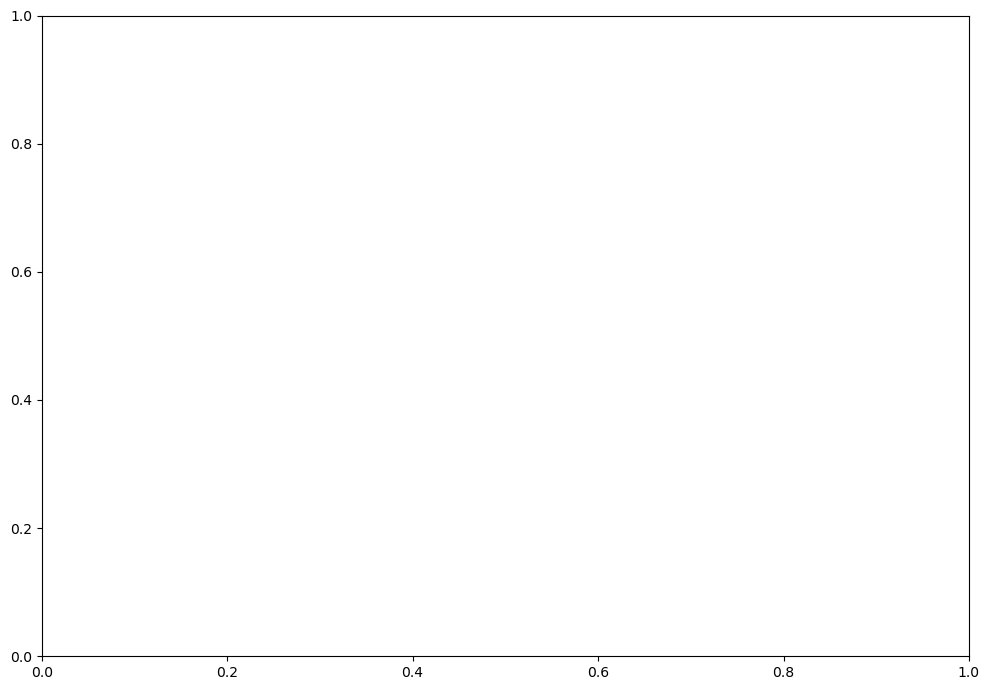

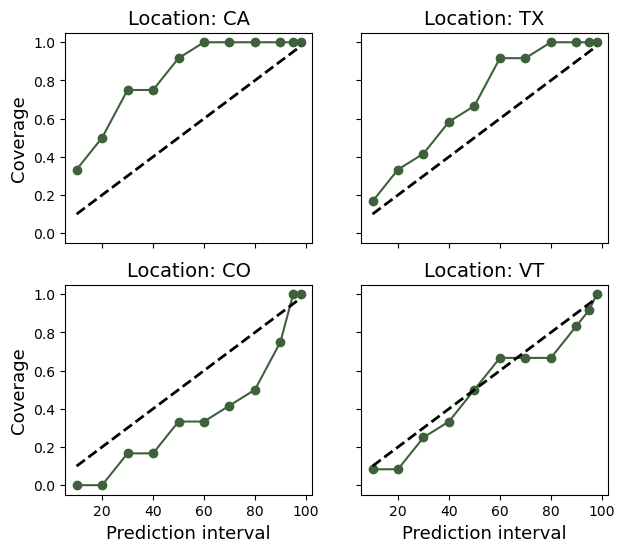

In [535]:
start_week = Week(2022,2)
end_week = Week(2022, 13)

incidence = True
target = 'case'

if target == 'hosp':
    target_obs = 'hospitalization'
elif target == 'death':
    target_obs = 'death'
else:
    target_obs = target

obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['Ensemble', 'Ensemble_LOP','Ensemble_LOP_untrimmed', 'JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 
              'USC-SIkJalpha', 'UVA-adaptive', 'UNCC-hierbin', 'UVA-EpiHiper' ]:
    df = pd.read_parquet(f'./dat/{model}_rd12.pq')
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target=target, incidence = True, max_date = False, 
                            start_week = start_week, end_week = end_week)
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])
    dfall = dfall[dfall.target_end_date <= pd.to_datetime(end_week.enddate())]


test2 = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target=target, incidence = True, max_date = False, 
                        start_week = start_week, end_week = end_week)
test2.get_coveragelocation_plot(titlename= 'coverageplotlocations_'+target)

Figure 3

In [543]:
rd = 12

df_hosp_mape = pd.read_pickle(f'./dat/dat_analysis/mapedf_hosp.pkl')
df_death_mape = pd.read_pickle(f'./dat/dat_analysis/mapedf_death.pkl')
df_case_mape = pd.read_pickle(f'./dat/dat_analysis/mapedf_case.pkl')

df_hosp_mape = df_hosp_mape.rename(columns= {"MAPE":"values","Model":"group"})
df_death_mape = df_death_mape.rename(columns= {"MAPE":"values","Model":"group"})
df_case_mape = df_case_mape.rename(columns= {"MAPE":"values","Model":"group"})


Ensemble_LOP_untrimmed 0.5837321746376312
Ensemble_LOP 0.5838125342191728
Ensemble 0.5987273229243377
UVA-EpiHiper 0.64602942672221
MOBS_NEU-GLEAM_COVID 0.6736126844218728
JHU_IDD-CovidSP 0.6861072466006635
UNCC-hierbin 0.7203474406310413
UVA-adaptive 0.9483659008447773
USC-SIkJalpha 2.704373539267966


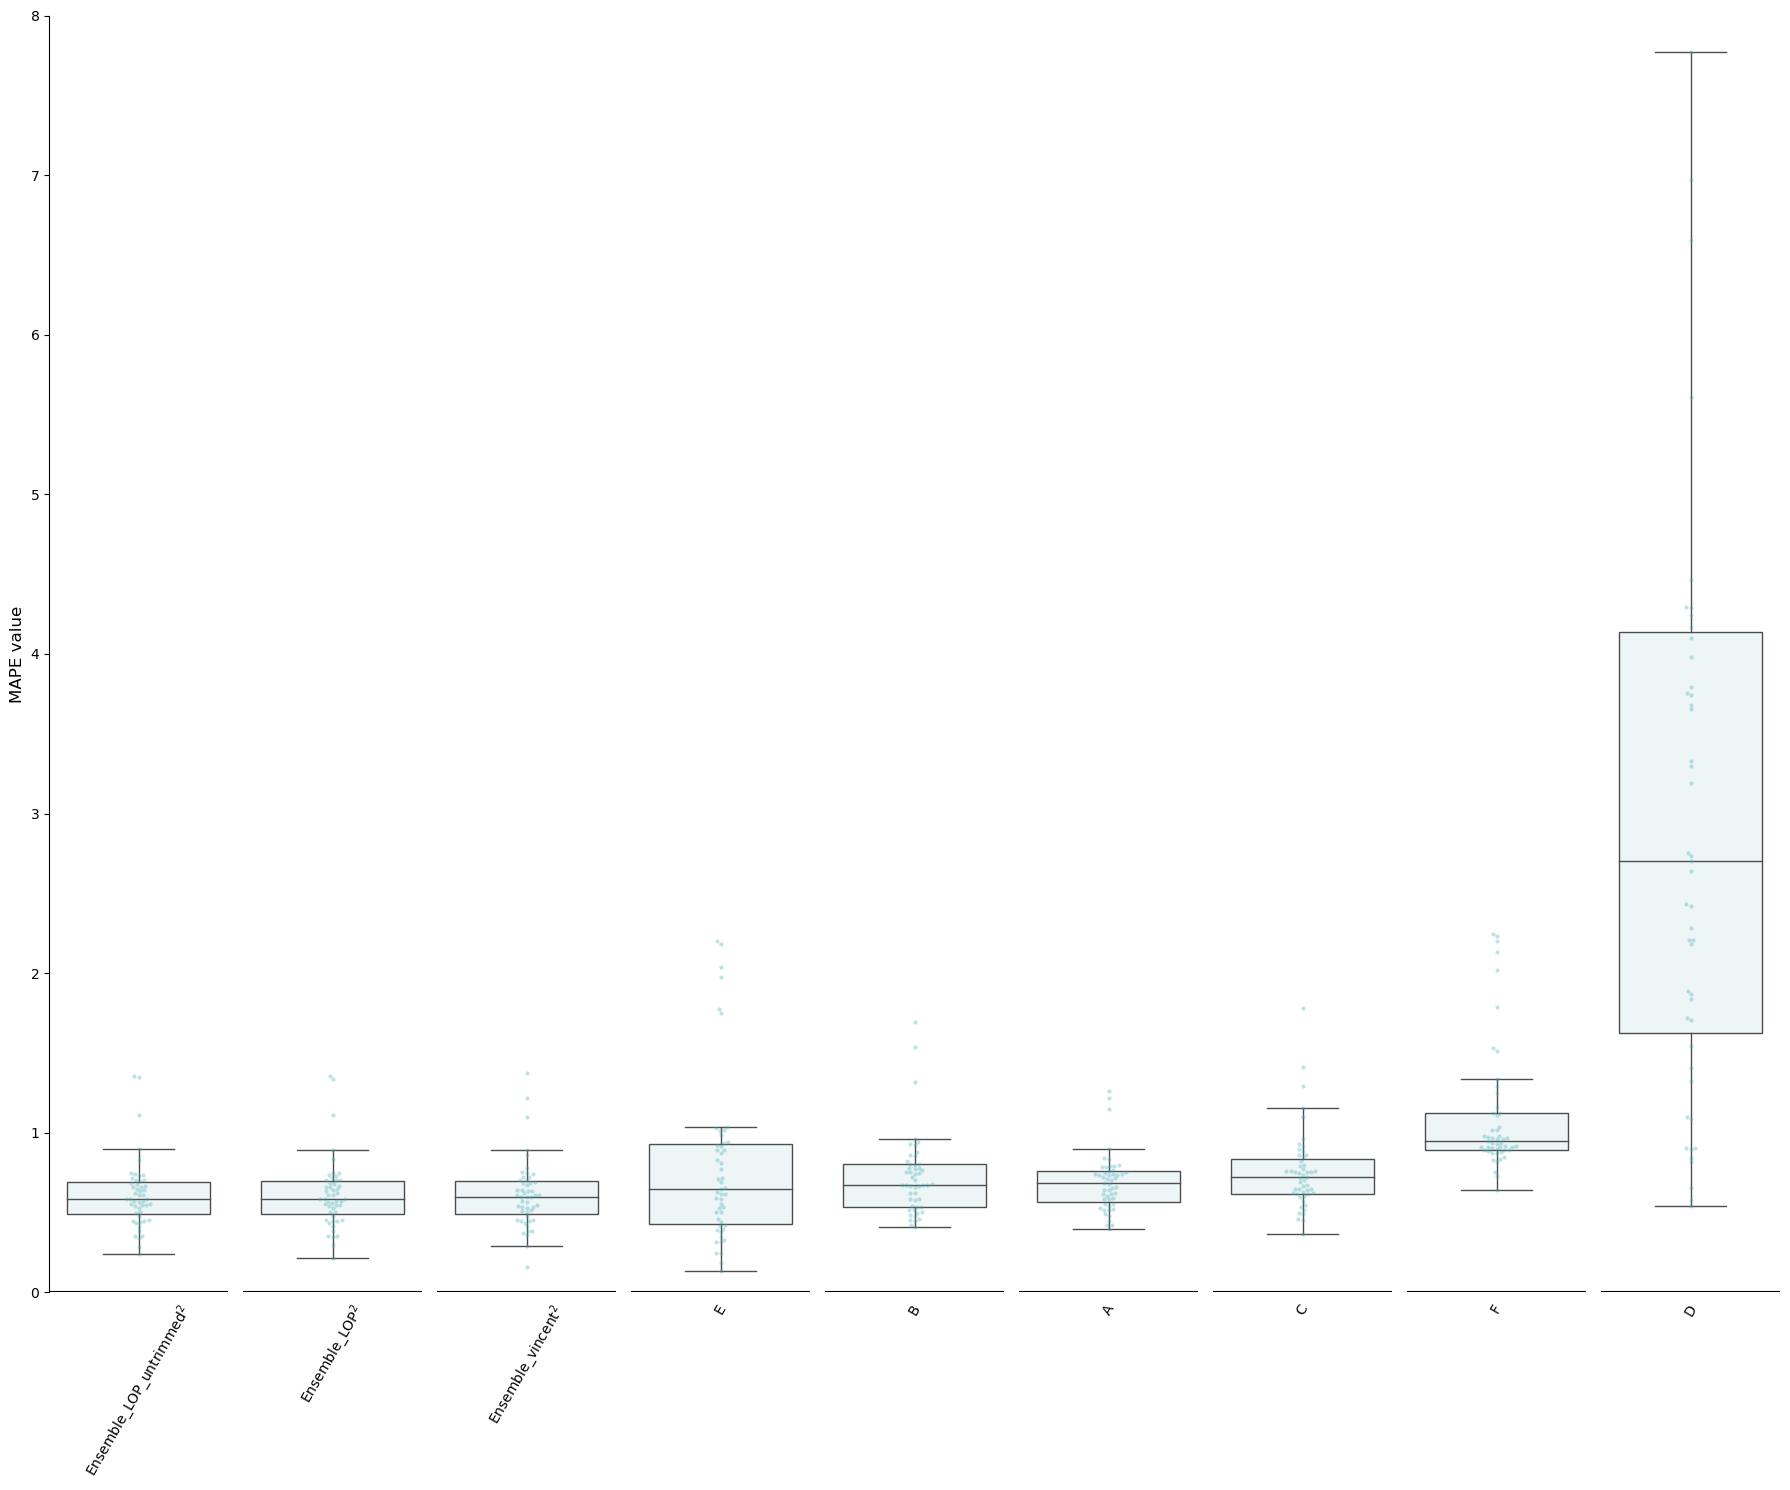

In [554]:
#mapealldf = wisnormalldf[wisnormalldf.WIS >= 0]


dfmape = df_death_mape_mape

dfmape = dfmape[dfmape.group != 'UTA-ImmunoSEIRS']
dfmape = dfmape[dfmape.group != 'NotreDame-FRED']


modelmap = {'Ensemble':r'Ensemble_vincent$^2$', "Ensemble_LOP":r"Ensemble_LOP$^2$","Ensemble_LOP_untrimmed":r"Ensemble_LOP_untrimmed$^2$",
            "JHU_IDD-CovidSP":'A', "MOBS_NEU-GLEAM_COVID":'B', "UNCC-hierbin":'C', "USC-SIkJalpha":'D', 
            "UVA-EpiHiper":'E', "UVA-adaptive":'F', 'CU-AGE-ST':'G', 'JHUAPL-Bucky':'H', 'Karlen-pypm':'I',
            "NCSU-COVSIM":'J', "NotreDame-FRED":'K', "UTA-ImmunoSEIRS":'L' }
        
models = list(dfmape.group.unique())
allmed = []
for model in models:
    med = dfmape[dfmape['group']== model]['values'].median()
    allmed.append(med)
    
a = zip(models, allmed)
a=list(a)
res = sorted(a, key = lambda x: x[1])
modelorder = list(zip(*res))[0]

dfmape.group = dfmape.group.astype("category")
dfmape.group = dfmape.group.cat.set_categories(modelorder)
dfmape.sort_values(["group"])
    
    
    
    
total_groups = dfmape.group.unique().shape[0]
total_min = 0 #data['values'].min()*-1.2
total_max = dfmape['values'].max()*1.2

fig, ax = plt.subplots(1,total_groups,figsize = (18,15),tight_layout = False)
plt.subplots_adjust(wspace=-.02)
i=0
for group, df in dfmape.groupby("group"):
    values = df["values"].values 
    print(group,np.median(values))
    
    sns.boxplot(values,ax = ax[i],color = "#49AFB7", showfliers = False, linewidth=1, orient="v")
    for patch in ax[i].patches:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .1))
    sns.swarmplot(values,ax = ax[i],color = "#49AFB7",alpha = .35,size=3, orient="v") 
    
    
    #ax[i].axis("off")
    
    ax[i].tick_params(bottom=False)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    
    ax[i].set_ylim(ymin = 0,ymax = 8)
    if i != 0:
        ax[i].set(yticklabels=[])
        ax[i].tick_params(left=False)
        
    groupnames = modelmap[group]
    text = "%s"
    #ax[i].text(1,-.075,groupnames,transform=ax[i].transAxes,  horizontalalignment= "right",\
    #           fontsize = 9, verticalalignment='center',backgroundcolor = "w", rotation=45)
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([groupnames], rotation=60, fontsize=10)
    
    ax[i].axhline(y = 0,xmin = -5,xmax= 5, color='black')
    
    i+=1
ax[0].axis("on")
#ax[0].set(xticklabels=[])
ax[0].tick_params(bottom=False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_visible(True)
ax[0].set_facecolor("none")
ax[0].set_ylabel('MAPE value', fontsize=12)

#ticks = ax[0].get_yticks()
#ax[0].tick_params(axis='y', labelsize=15)
    
#plt.suptitle('MAPE Distributions for All Scenario Ensemble Targets, Round 12', fontsize=16)
#plt.savefig('MAPEdist_vert_111_death.pdf')
plt.show()

In [542]:
mapealldf = mapealldf[mapealldf.group != 'UTA-ImmunoSEIRS']


,group,Location,Population,values
0,Ensemble,Alabama,4903185.0,0.485226
1,Ensemble,Alaska,731545.0,0.390487
2,Ensemble,Arizona,7278717.0,0.519135
3,Ensemble,Arkansas,3017804.0,0.543412
4,Ensemble,California,39512223.0,0.538554
...,...,...,...,...
148,Ensemble_LOP_untrimmed,Virginia,8535519.0,0.360451
149,Ensemble_LOP_untrimmed,Washington,7614893.0,0.328245
150,Ensemble_LOP_untrimmed,West Virginia,1792147.0,0.572213
151,Ensemble_LOP_untrimmed,Wisconsin,5822434.0,0.212944


In [555]:
mpl.__version__ # need version 3.5.1

'3.7.1'

In [ ]:
# figures in penguinplot notebook bc need different matplotlib version

Figure 4

In [562]:
file = open('./dat/dat_analysis/avgcov_all_case_518', 'rb')

# dump information to that file
avgcov_all_case = pickle.load(file)

# close the file
file.close()

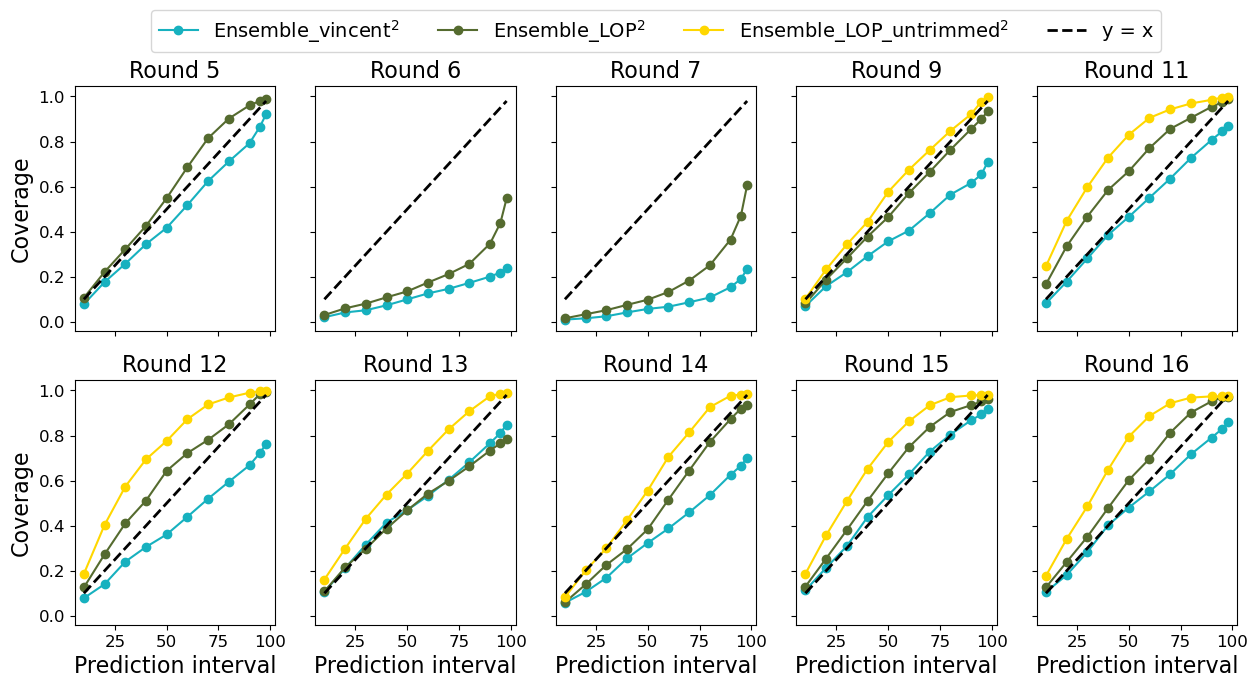

In [607]:
plt.subplots(2,5,figsize=(15,7), sharey=True, sharex=True)
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]

covers = [10,20,30,40,50,60,70,80,90,95,98]
covsy = [cv/100 for cv in covers]
numobs = [7, 19, 19, 14, 12, 12, 19, 19, 19, 18]
numobs = [7, 26, 24, 14, 12, 12, 51, 39, 31, 18]

j=1
for rd in rds:
    ensem = np.zeros(11)
    ensemlop = np.zeros(11)
    ensemlop_untrim = np.zeros(11)

    nensem = 0
    nlop = 0
    nlopuntrim = 0
    
    for d in [avgcov_all_case]:
        dic = d[rd]

        models = list(dic.keys())

        for model in models:
            if model == 'Ensemble':
                ensem = ensem + dic[model]
                nensem += numobs[j-1]
            elif model == 'Ensemble_LOP':
                ensemlop = ensemlop + dic[model]
                nlop += numobs[j-1]
            elif model == 'Ensemble_LOP_untrimmed':
                ensemlop_untrim = ensemlop_untrim + dic[model]
                nlopuntrim += numobs[j-1]
    ensemavg = [i/nensem for i in ensem]
    lopavg = [i/nlop for i in ensemlop]
    untrimavg = [i/nlopuntrim for i in ensemlop_untrim]    
        
    plt.subplot(2,5,j)
    plt.plot(covers, ensemavg, '-o', color = '#17B1BF',label = r'Ensemble_vincent$^2$')
    plt.plot(covers, lopavg, '-o', color = 'darkolivegreen', label = 'Ensemble_LOP$^2$')
    plt.plot(covers, untrimavg, '-o', color = 'gold', label = 'Ensemble_LOP_untrimmed$^2$')
    plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2)  

    plt.title('Round '+ str(rd), fontsize=16)
    if j in [6, 7,8,9, 10]:
        plt.xlabel('Prediction interval', fontsize=16)
        plt.xticks(fontsize=12)
    
    if j in [1,6]:
        plt.ylabel('Coverage', fontsize=16)
        plt.yticks(fontsize=12)
    
   
    if j == 3:
        plt.legend(bbox_to_anchor=(.5, 1.35), loc='upper center', fontsize=14, ncol=4)

    j +=1    
plt.tight_layout()

plt.savefig('coverage_allrds_case_111.pdf')
plt.show()

Figure 5

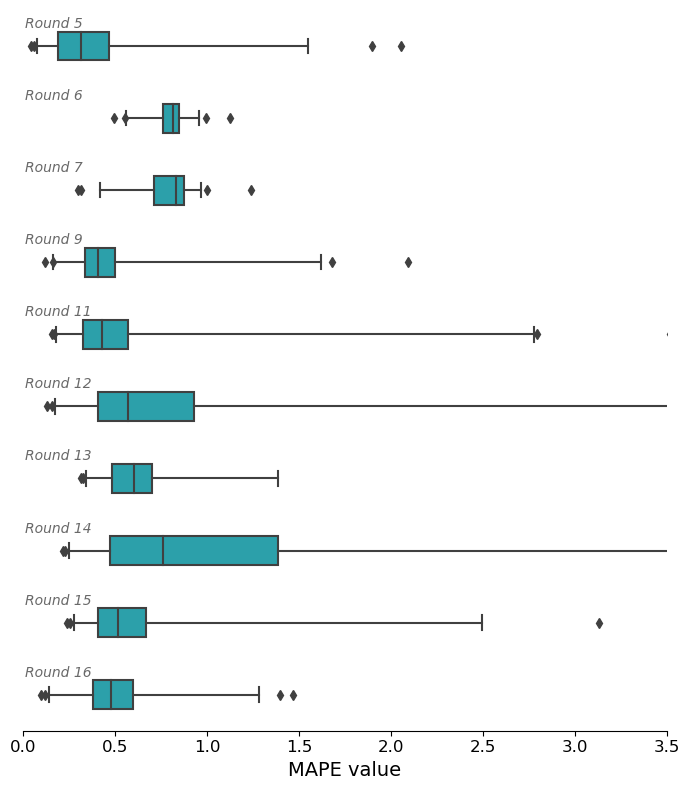

In [105]:
#MAPE


fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)

rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
model = 'Ensemble'
i=1
dfuse = pd.DataFrame()
for rd in rds:
    
   # df = pd.read_pickle(f'mapeval_{target}_rd{rd}_517_all.pkl')
    
    for target in ['hosp', 'case', 'death']:
        df = pd.read_pickle(f'./dat/dat_analysis/mapeval_{target}_rd{rd}_517_all.pkl')
        
        df['Round'] = rd

        dfmod = df[df.Model == model]
    
       # dfmod = dfmod[dfmod.MAPE >= 0] # remove locations where mean WIS is less than zero, not possible?
        
        dfuse = pd.concat([dfuse, dfmod])
    
        #print(rd, dfmod.MAPE.max())

my_order = dfuse.groupby(by=['Round'])['Round'].median().sort_values(ascending=True).index
    
g = sns.boxplot(x='MAPE', y='Round', data=dfuse,order=my_order, color = '#17B1BF', orient='h', 
                width=.4, whis=[1, 99])

g.set(yticklabels=[])
g.set(yticks=[])

plt.xlabel('MAPE value', fontsize=14)
    
plt.ylabel('', fontsize=14)

a = 0
for mod in list(my_order):
    plt.text(0.01,a-.25, 'Round ' + str(mod), fontsize=10, style='italic', color='dimgray')
    a+=1
    
plt.xlim([0,3.5]) # cuts off some outliers
    
i+=1
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
    
#plt.suptitle(r'MAPE values for Ensemble$^2$ Model for all targets and locations', fontsize=12)
plt.tight_layout()
#plt.savefig('EnsembleLOP_MAPEvals_hosp_111.pdf')
plt.show()
    

In [106]:
WISagg = pd.read_pickle('./dat/dat_analysis/WISagg_stdev.pkl')

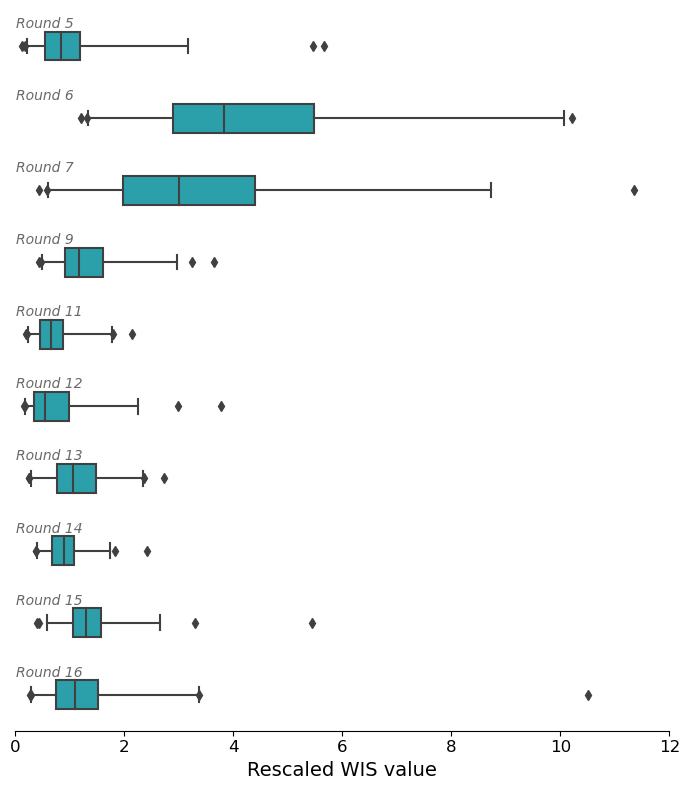

In [108]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)

rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
model = 'Ensemble'
i=1
dfuse = pd.DataFrame()
for rd in rds:
    for target in ['case', 'death', 'hosp']:
        dfa = WISagg[WISagg.Target == target]
        df = dfa[dfa.Round == rd]
        
        #df['Round'] = rd

        dfmod = df[df.Model == model]
    
        dfmod = dfmod[dfmod.WISscaled >= 0] # remove locations where mean WIS is less than zero, not possible?
        
        dfuse = pd.concat([dfuse, dfmod])
    
my_order = dfuse.groupby(by=['Round'])['Round'].median().sort_values(ascending=True).index
    
g = sns.boxplot(x='WISscaled', y='Round', data=dfuse,order=my_order, color = '#17B1BF', orient='h', 
                width=.4, whis=[1, 99])

g.set(yticklabels=[])
g.set(yticks=[])


plt.xlabel('Rescaled WIS value', fontsize=14)

plt.ylabel('', fontsize=14)

a = 0
for mod in list(my_order):
    plt.text(0.01,a-.25, 'Round ' + str(int(mod)), fontsize=10, style='italic', color='dimgray')
    a+=1


plt.xlim([0,12]) # cuts off some outliers

i+=1
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
#plt.suptitle(r'Normalized WIS values for Ensemble$^2$ Model for all targets and locations', fontsize=12)
plt.tight_layout()
#plt.savefig('EnsembleLOP_WISstd_case_111.pdf')
plt.show()


Figure 6

In [66]:
modelmap = {'Ensemble':r'Ensemble_vincent$^2$', "Ensemble_LOP":r"Ensemble_LOP$^2$","Ensemble_LOP_untrimmed":r"Ensemble_LOP_untrimmed$^2$",
            "JHU_IDD-CovidSP":'A', "MOBS_NEU-GLEAM_COVID":'B', "UNCC-hierbin":'C', "USC-SIkJalpha":'D', 
            "UVA-EpiHiper":'E', "UVA-adaptive":'F', 'CU-AGE-ST':'G', 'JHUAPL-Bucky':'H', 'Karlen-pypm':'I',
            "NCSU-COVSIM":'J', "NotreDame-FRED":'K', "UTA-ImmunoSEIRS":'L' }
 

In [72]:
# work on standard rank plot layout
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
dfrankall = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank','Target','Round'])
for rd in rds:
   # dfa = pd.read_pickle(f'./dat/dat_analysis/WISdf_rd{rd}_525.pkl')
    
    for target in ['hosp']:
        dfa = pd.read_pickle(f'./dat/dat_analysis/allmodel_wis_{target}_rd{rd}_525_all.pkl')
        
        dfrank = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank','Target','Round'])
        
        df = dfa[dfa['Target'] == target]

        states = list(df.Location.unique())

        for state in states:
            filt = df[df['Location']==state]
            #filt = filt.sort_values('avgnormWIS_std')
            filt = filt.sort_values('WIS')

            rank = list(filt.Model)
            for model in rank:
                rankval = 1 - rank.index(model)/(len(rank)-1)

                new_row = {'Model':model, 'Location': state, 'Standard_Rank': rankval, 'Target':target, 'Round':rd}

                dfrank = dfrank.append(new_row, ignore_index=True)
                
        dfrankall = pd.concat([dfrankall, dfrank])
dfrankallwis = dfrankall.reset_index()


dfrankallwis['ModelID'] = dfrankallwis['Model'].map(modelmap)



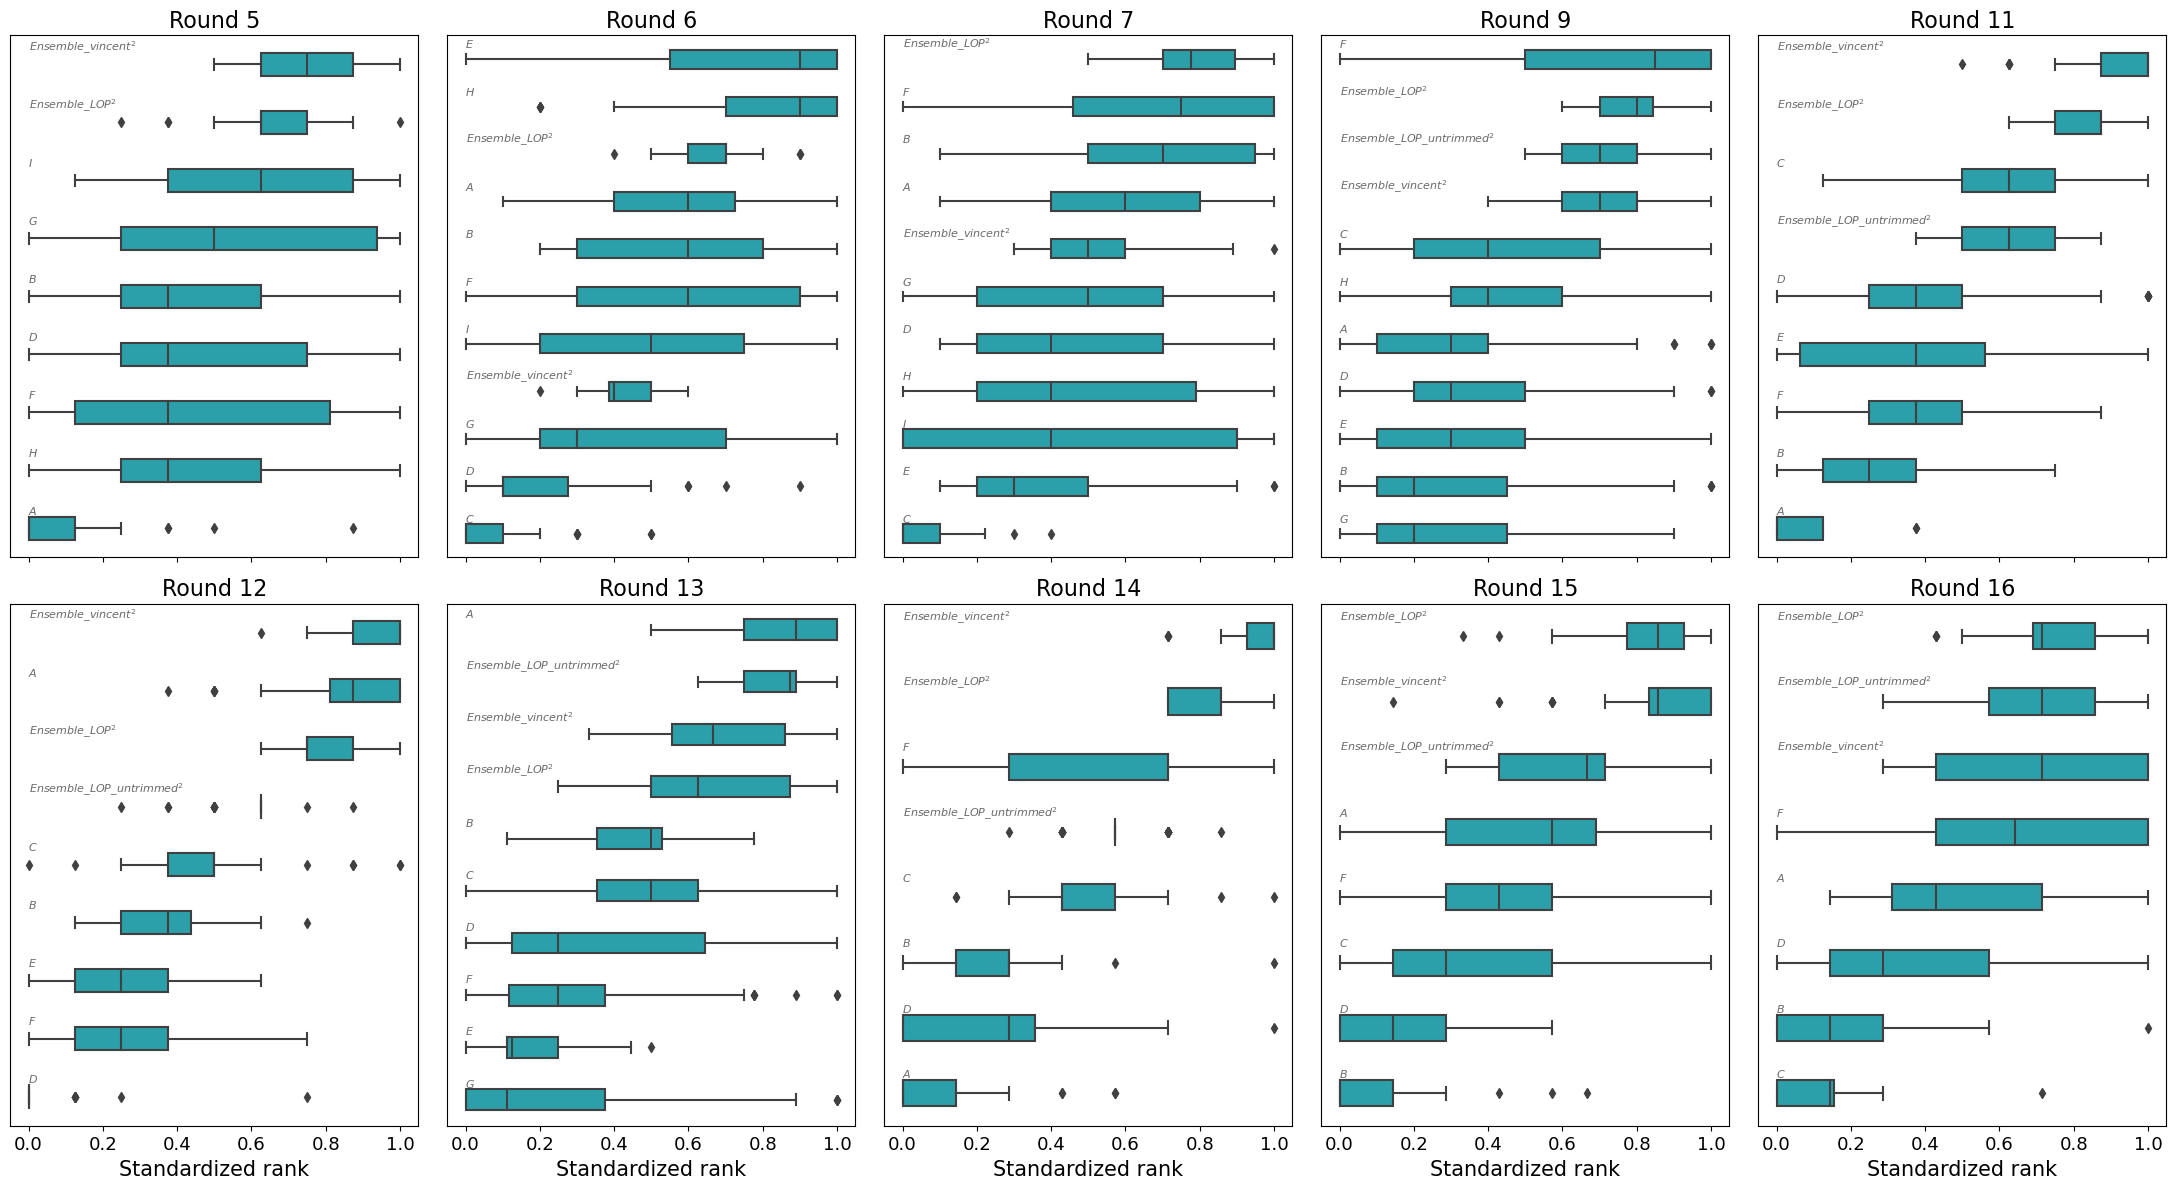

In [73]:
plt.subplots(2,5,figsize=(22,12), sharex=True)
#plt.subplots_adjust(hspace=4)
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
#rds=[5]
i=1
for rd in rds:
    plt.subplot(2,5,i)
    
    rankinfo = dfrankallwis[dfrankallwis.Round == rd]
    
    
    my_order = rankinfo.groupby(by=["ModelID"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    g = sns.boxplot(x='Standard_Rank', y='ModelID', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 6]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [6, 7, 8, 9, 10]:
        plt.xlabel('Standardized rank', fontsize=15)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title('Round '+str(rd), fontsize=16)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.25, mod, fontsize=8, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
#plt.suptitle('Standardized Rank of Normalized WIS values for all targets', fontsize=20)
plt.tight_layout()
plt.savefig('./rebuttal_figs/standardrank_WIS_hosp_111.pdf')
plt.show()


Figure 8

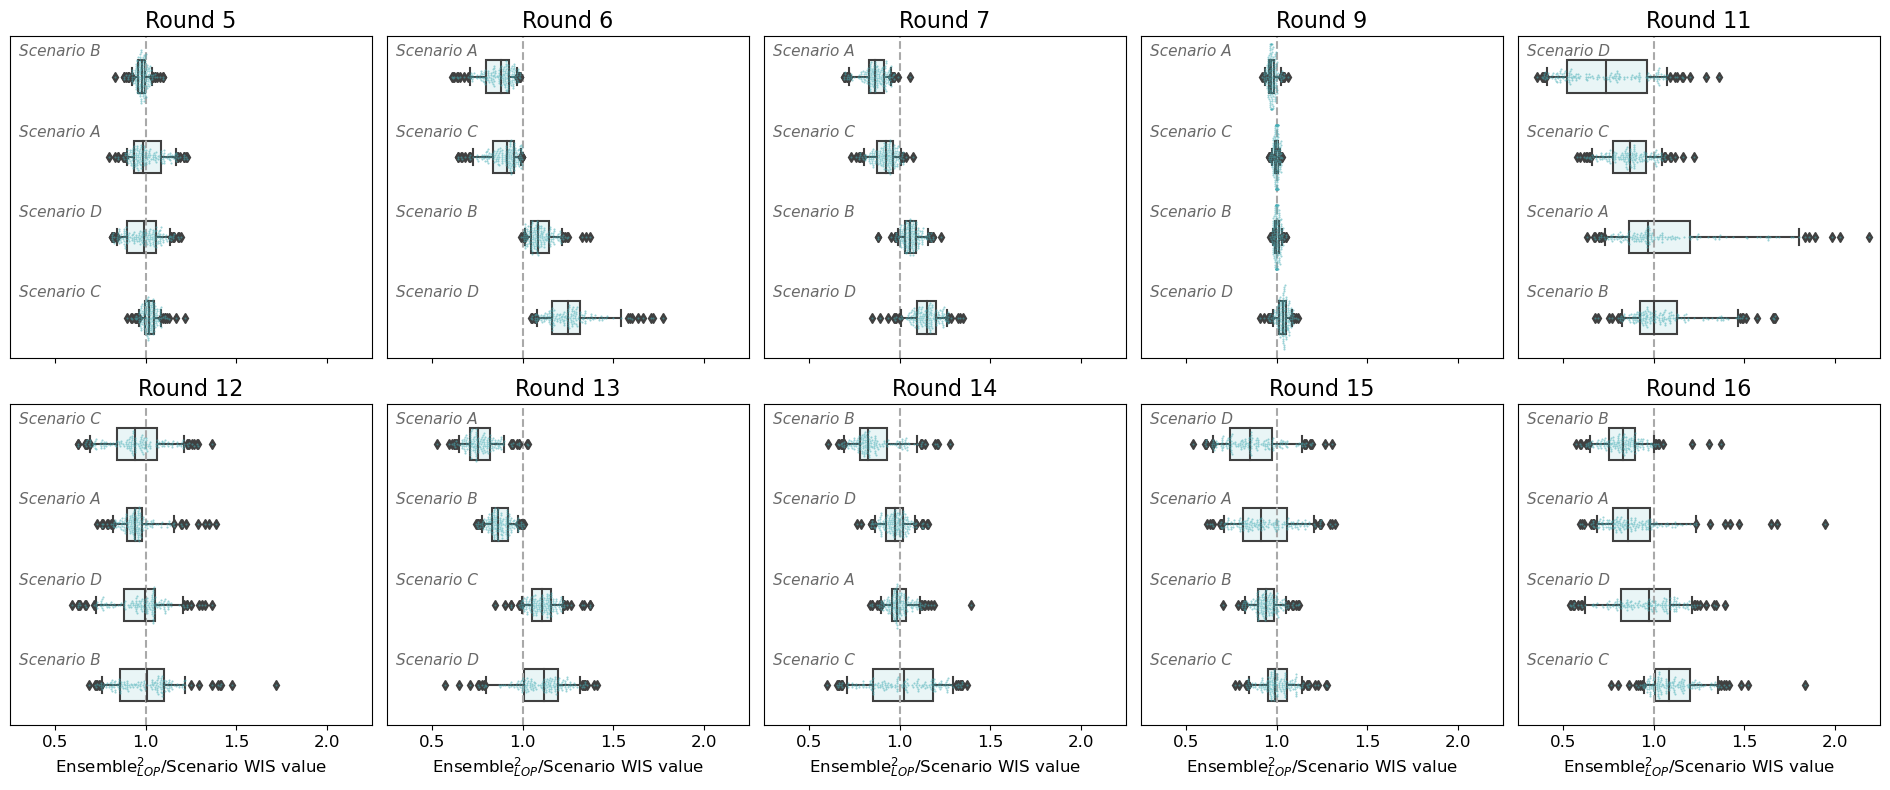

In [99]:
plt.subplots(2,5,figsize=(19,8), sharex=True)
scenariomap = {'Median aggregate': 'Scenario ensemble', 'Scenario A':'Scenario A', 'Scenario B':'Scenario B', 
              'Scenario C':'Scenario C', 'Scenario D':'Scenario D', 'Baseline':'COVIDhub-ensemble_4wks'}

rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
#rds=[5]
i=1
dfallrd = pd.DataFrame()
for rd in rds:
    plt.subplot(2,5,i)
    dfrd = pd.DataFrame() 
    plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'darkgray', alpha=1)
    for target in ['death', 'case', 'hosp']:
    #for target in ['death']:
        df = pd.read_pickle(f'./dat/dat_analysis/allscenario_wis_{target}_rd{rd}_526.pkl')

        #forecastens = pd.read_pickle(f'./dat/dat_analysis/baselinemodels_wis_{target}_rd{rd}_525.pkl')
        #forecastens = forecastens[forecastens.Model == 'COVIDhub-ensemble_4wks']
        #forecastens = forecastens[forecastens.WIS > 0]

        baseline = df[df.Label == 'Median aggregate']
        baseline = baseline[baseline.WIS > 0]
        
        
        dfmod = df[df.Label != 'Median aggregate']
        dfmod = dfmod[dfmod.WIS >= 0] # remove locations where mean WIS is less than zero, not possible?
        
        dfmerge = pd.merge(dfmod, baseline, how ='inner', on ='Location')
        dfmerge['Scenariocomp'] = dfmerge['WIS_y']/dfmerge['WIS_x']
        
        
        
        
    
           # dfmod = dfmod[dfmod.MAPE >= 0] # remove locations where mean WIS is less than zero, not possible?
        dfrd = pd.concat([dfrd, dfmerge])
        
        
        #dfbase = pd.merge(forecastens, baseline, how ='inner', on ='Location')
        
        #dfbase['Scenariocomp'] = dfbase['WIS_y']/dfbase['WIS_x']
        
        #dfrd = pd.concat([dfrd, dfbase])
        
        dfrd['Round'] = rd
        
        dfallrd = pd.concat([dfallrd, dfrd])
        
    #break
    
    my_order = dfrd.groupby(by=['Label_x'])['Scenariocomp'].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='Scenariocomp', y='Label_x', data=dfrd, order = my_order, color = '#17B1BF', width=0.4,
                   whis=[5,95])
    
    for patch in g.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))
   
    sns.swarmplot(x='Scenariocomp', y='Label_x', data=dfrd,order=my_order,color = "#49AFB7",alpha = .55,size=1.5, orient="h")    

    
    g.set(yticklabels=[])
    g.set(yticks=[])
    
    g.set(ylabel=None)
        
    if i in [6, 7, 8, 9, 10]:
        plt.xlabel('Ensemble$_{LOP}^2$/Scenario WIS value', fontsize=12)
    else:
        g.set(xlabel=None)
      #  g.set(xticks=[])
        
    a = 0
    for mod in list(my_order):
        plt.text(0.3,a-.25, scenariomap[mod], fontsize=11, style='italic', color='dimgray')
        a+=1

    i+=1 
    plt.title('Round '+str(rd), fontsize=16)
    plt.yticks(fontsize=13)
    
    plt.xlim([0.25,2.25]) # cuts off some outliers
    
#plt.suptitle('Standardized Rank of MAPE values for Deaths at all Locations', fontsize=20)
plt.tight_layout()
#plt.savefig('scenariocomp_WIS_death_111.pdf')
plt.show()

In [657]:
scenworst = pd.DataFrame()
scenbest = pd.DataFrame()
for rd in rds:
    a = dfallrd[dfallrd.Round==rd]
    b = a[a.Model_x == 'Ensemble_LOP'].groupby(['Label_x'])['Scenariocomp'].median().sort_values(ascending=True).index
    
    
    for s in [b[0]]:
        s1 = a[a.Label_x == s]
        scenworst = pd.concat([scenworst, s1])
        

    for s in [b[-1]]:
        s2 = a[a.Label_x == s]
        scenbest = pd.concat([scenbest, s2])

In [658]:
scenbest.groupby(['Round'])['Scenariocomp'].median()

Round
5     1.016693
6     1.246818
7     1.156038
9     1.035097
11    0.975408
12    1.030209
13    1.087398
14    1.038050
15    0.986299
16    1.048578
Name: Scenariocomp, dtype: float64

In [656]:
scenworst.groupby(['Round'])['Scenariocomp'].median()

Round
5     0.978260
6     0.888595
7     0.865164
9     0.971680
11    0.741844
12    0.933230
13    0.774187
14    0.827497
15    0.852134
16    0.844213
Name: Scenariocomp, dtype: float64

# Fig 7 - log scale

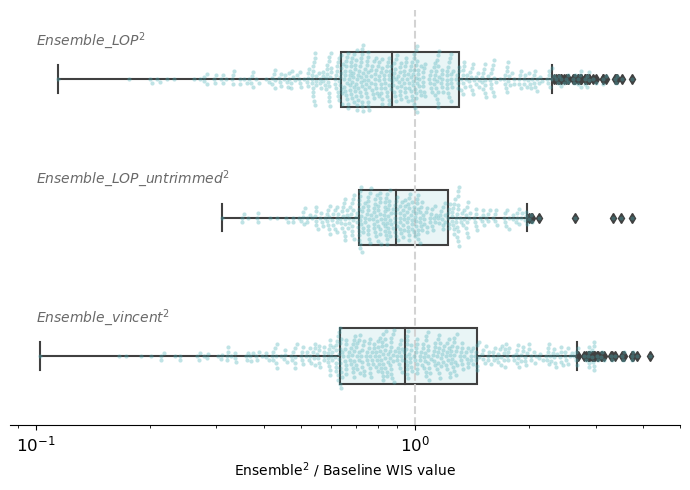

In [100]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
#models = ['Ensemble','Ensemble_LOP', 'Ensemble_LOP_untrimmed', 'COVIDhub-baseline']
models = ['Ensemble_LOP',  'Ensemble','Ensemble_LOP_untrimmed']
i=1
target= 'death'

dfallrd = pd.DataFrame() 

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
for model in models:
    if model == 'Ensemble_LOP_untrimmed':
        rds =  [ 9, 11, 12, 13, 14 ,15, 16]
    else:
        rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
        
    
    for rd in rds:
        baseline = pd.read_pickle(f'./dat/dat_analysis/baselinemodels_wis_{target}_rd{rd}_525.pkl')
        baseline = baseline[baseline.Model == 'COVIDhub-baseline_4wks']
        baseline = baseline[baseline.WIS > 0]
        
        df = pd.read_pickle(f'./dat/dat_analysis/allmodel_wis_{target}_rd{rd}_525_all.pkl')

        dfmod = df[df.Model == model]
        dfmod = dfmod[dfmod.WIS >= 0] # remove locations where mean WIS is less than zero, not possible?
        
        dfmerge = pd.merge(dfmod, baseline, how ='inner', on ='Location')
        dfmerge['Modelcomp'] = dfmerge['WIS_x']/dfmerge['WIS_y']
        
        

           # dfmod = dfmod[dfmod.MAPE >= 0] # remove locations where mean WIS is less than zero, not possible?
        dfallrd = pd.concat([dfallrd, dfmerge])

my_order = dfallrd.groupby(by=['Model_x'])['Modelcomp'].median().sort_values(ascending=True).index
g = sns.boxplot(x='Modelcomp', y='Model_x', data=dfallrd,order=my_order, color = '#17B1BF',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))

    
sns.swarmplot(x='Modelcomp', y='Model_x', data=dfallrd,order=my_order,color = "#49AFB7",alpha = .35,size=3, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

g.set(xlabel='Ensemble$^2$ / Baseline WIS value ')


#plt.xlim([0,4]) # cuts off some outliers

a = 0
for mod in list(my_order):
    plt.text(.1,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.xscale("log")

#plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
plt.tight_layout()
#plt.savefig('baselinecomp_WISvals_logscale_111.pdf')
plt.show()

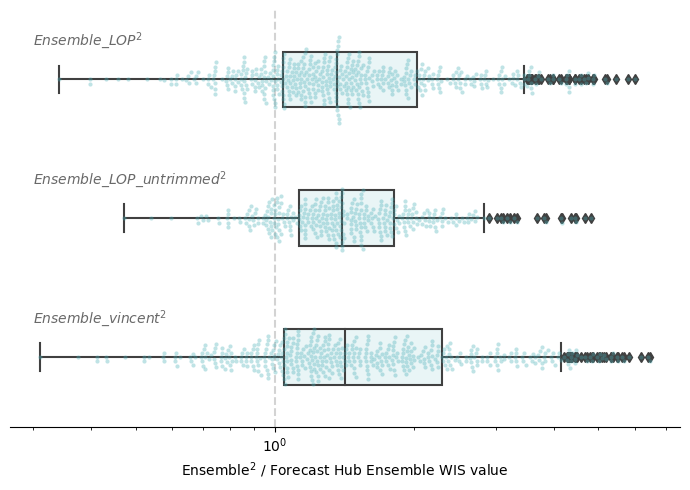

In [670]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
#models = ['Ensemble','Ensemble_LOP', 'Ensemble_LOP_untrimmed', 'COVIDhub-baseline']
models = ['Ensemble_LOP',  'Ensemble','Ensemble_LOP_untrimmed']
i=1
target= 'death'

dfallrd = pd.DataFrame() 

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
for model in models:
    if model == 'Ensemble_LOP_untrimmed':
        rds =  [ 9, 11, 12, 13, 14 ,15, 16]
    else:
        rds = [ 5, 6, 7, 9, 11, 12, 13, 14 ,15, 16]
        
    
    for rd in rds:
        baseline = pd.read_pickle(f'./dat/dat_analysis/baselinemodels_wis_{target}_rd{rd}_525.pkl')
        baseline = baseline[baseline.Model == 'COVIDhub-ensemble_4wks']
        baseline = baseline[baseline.WIS > 0]
        
        df = pd.read_pickle(f'./dat/dat_analysis/allmodel_wis_{target}_rd{rd}_525_all.pkl')

        dfmod = df[df.Model == model]
        dfmod = dfmod[dfmod.WIS >= 0] # remove locations where mean WIS is less than zero, not possible?
        
        dfmerge = pd.merge(dfmod, baseline, how ='inner', on ='Location')
        dfmerge['Modelcomp'] = dfmerge['WIS_x']/dfmerge['WIS_y']
        
        

           # dfmod = dfmod[dfmod.MAPE >= 0] # remove locations where mean WIS is less than zero, not possible?
        dfallrd = pd.concat([dfallrd, dfmerge])

my_order = dfallrd.groupby(by=['Model_x'])['Modelcomp'].median().sort_values(ascending=True).index
g = sns.boxplot(x='Modelcomp', y='Model_x', data=dfallrd,order=my_order, color = '#17B1BF',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))

    
sns.swarmplot(x='Modelcomp', y='Model_x', data=dfallrd,order=my_order,color = "#49AFB7",alpha = .35,size=3, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

g.set(xlabel='Ensemble$^2$ / Forecast Hub Ensemble WIS value ')


#plt.xlim([0,4]) # cuts off some outliers

a = 0
for mod in list(my_order):
    plt.text(0.3,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.xscale("log")

#plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
plt.tight_layout()
plt.savefig('forecastensemblecomp_WIS_logscale_111.pdf')
plt.show()